# To do:

 - Both
     - Fix Injuries data
         - Find a better source for roster data
 - Mins
     - Figure out how to distribute mins for injury riddled games

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import duckdb
import warnings
import os

import xgboost as xgb
from xgboost import XGBRegressor
from scipy.stats import randint, uniform

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import joblib
import warnings
from datetime import datetime, timedelta

pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

categories = ['PTS', 'AST', 'REB', 'PR', 'PA', 'RA', 'PRA', 'TPM', 'STL', 'BLK', 'STL_BLK']
con = duckdb.connect(database=":memory:")

cwd = os.path.abspath(os.getcwd()).replace("\\", "/")
if cwd.startswith("C:/Users/Rodolfo/"):
    RUN_LOCATION = "local"
else:
    RUN_LOCATION = "cloud"
time_offset = {"local": 3, "cloud": -5}
now = str((datetime.now() + timedelta(hours=time_offset[RUN_LOCATION]) + timedelta(hours=-3)).date())
print(f"Today's date:", now)

tgt_stat = "PTS"
print('Target Stat:', tgt_stat)

Today's date: 2026-01-10
Target Stat: PTS


In [2]:
%run ./common_utils.ipynb

# ML Functions

In [3]:
def feature_importance(model, all_features):
    # Get gain importance
    importance = model.get_score(importance_type='gain')
    
    # Fill in 0 for missing features
    df_importance = pd.DataFrame({
        'feature': all_features,
        'importance': [importance.get(f, 0) for f in all_features]
    }).sort_values(by='importance', ascending=False).reset_index(drop=True)
    
    df_importance['pct'] = df_importance.importance.cumsum() / df_importance.importance.sum()
    if df_importance.shape[0] >= 50:
        with pd.option_context('display.max_rows', None):
            display(df_importance)
    else:
        display(df_importance)
    
    xgb.plot_importance(model)
    plt.show()

In [4]:
def create_baseline_model(df, pred_col, DFS):
    
    train_df, val_df, test_df = DFS

    if pred_col == 'MP':
        print('Minutes Model')
        feature_cols = [
            'MP_L3_avg', 'MP_L5_avg', 'MP_L10_avg', 'game_spread_type'
        ]
    else:
        print(f'{pred_col} Stats Model')
        feature_cols = [
            'MP_L5_avg',
            'MP_L10_avg',
            f'{pred_col}_last_3_avg', f'{pred_col}_last_5_avg', f'{pred_col}_last_10_avg',
            f'Def_{pred_col}', f'Def_L5_{pred_col}'
        ]
    
    print('Train:', len(train_df), '/ Validation:', len(val_df), '/ Test:', len(test_df))
    
    X_train, y_train = train_df[feature_cols], train_df[pred_col]
    X_val,   y_val   = val_df[feature_cols],   val_df[pred_col]
    X_test,  y_test  = test_df[feature_cols],  test_df[pred_col]

    # Convert to DMatrix (XGBoost internal format)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval   = xgb.DMatrix(X_val, label=y_val)
    dtest  = xgb.DMatrix(X_test, label=y_test)

    params = {
        "objective": "reg:squarederror",
        "max_depth": 5,
        "learning_rate": 0.05,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "seed": 42
    }

    # Train using native XGBoost API with early stopping
    evals = [(dtrain, "train"), (dval, "val")]
    bst = xgb.train(
        params,
        dtrain,
        num_boost_round=500,
        evals=evals,
        early_stopping_rounds=50,
        verbose_eval=False
    )

    # Predict on test set
    preds = bst.predict(dtest)

    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    print("RMSE:", rmse)
    print("MAE:", mae)
    print("R²:", r2)
    
    return bst

In [5]:
def hyperparam_tuning(DFS, pred_col, n_iter=20, early_stopping_rounds=50):
    """
    Hyperparameter tuning using native XGBoost API and DMatrix,
    with early stopping support (compatible with XGBoost 3.1.2)
    """

    train_df, val_df, test_df = DFS
    feature_cols = [col for col in train_df.columns if col not in ['Date', pred_col]]
    X_train, y_train = train_df[feature_cols], train_df[pred_col]
    X_val,   y_val   = val_df[feature_cols],   val_df[pred_col]
    X_test,  y_test  = test_df[feature_cols],  test_df[pred_col]

    # Convert datasets to DMatrix
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval   = xgb.DMatrix(X_val, label=y_val)
    dtest  = xgb.DMatrix(X_test, label=y_test)

    # Hyperparameter search space
    param_dist = {
        "n_estimators": randint(300, 1500),
        "learning_rate": uniform(0.01, 0.05),
        "max_depth": randint(3, 6),
        "min_child_weight": randint(1, 8),
        "subsample": uniform(0.7, 0.3),
        "colsample_bytree": uniform(0.7, 0.3),
        "gamma": uniform(0, 2),
        "reg_lambda": uniform(0, 5),
        "reg_alpha": uniform(0, 2)
    }

    # Sample n_iter random parameter combinations
    param_list = []
    for _ in range(n_iter):
        sample = {k: (v.rvs() if hasattr(v, "rvs") else v) for k, v in param_dist.items()}
        sample['n_estimators'] = int(sample['n_estimators'])
        sample['max_depth'] = int(sample['max_depth'])
        sample['min_child_weight'] = int(sample['min_child_weight'])
        param_list.append(sample)

    best_mae = float('inf')
    best_params = None
    best_bst = None
        
    # Manual hyperparameter search
    for i, params in enumerate(param_list):
        print(f"\nTrial {i+1}/{n_iter}: {params}")
        num_boost_round = params.pop('n_estimators')
        params.update({
            "objective": "reg:squarederror",
            "tree_method": "hist",
            "device": "cuda",
            "seed": 42
        })
        evals = [(dtrain, 'train'), (dval, 'val')]
        bst = xgb.train(
            params,
            dtrain,
            num_boost_round=num_boost_round,
            evals=evals,
            early_stopping_rounds=early_stopping_rounds,
            verbose_eval=False
        )
        # Predict on validation set to compute MAE
        val_preds = bst.predict(dval, iteration_range=(0, bst.best_iteration))
        mae = mean_absolute_error(y_val, val_preds)
        print(f"Validation MAE: {mae:.4f}")
        if mae < best_mae:
            best_mae = mae
            best_params = params.copy()
            best_bst = bst

    print("\nBest validation MAE:", best_mae)
    print("Best parameters:", best_params)

    # Predict on test set using best model
    preds = best_bst.predict(dtest, iteration_range=(0, best_bst.best_iteration))
    test_df[pred_col] = y_test
    test_df[f'{pred_col}_preds'] = preds
    test_df['Team'] = team_encoder.inverse_transform(test_df["Team"])
    test_df['Opp'] = team_encoder.inverse_transform(test_df["Opp"])
    test_df['Player'] = player_encoder.inverse_transform(test_df["Player"])
    test_df['Pos'] = position_encoder.inverse_transform(test_df["Pos"])
    analyze_df = test_df[['Date', 'Team', 'Player', 'Pos', 'Opp', pred_col, f'{pred_col}_preds']]
    print("\nTest Metrics:")
    print("RMSE:", np.sqrt(mean_squared_error(y_test, preds)))
    print("MAE:", mean_absolute_error(y_test, preds))
    print("R²:", r2_score(y_test, preds))

    return best_bst, preds, y_test, analyze_df

### Create Base df

In [6]:
def load_df(file_name):
    df = pd.DataFrame()
    for i in [2021, 2022, 2023, 2024, 2025]:
        df_temp = pd.read_csv(f"../tables/{i}/{file_name}.csv")
        df_temp['Season'] = i
        df = pd.concat([df, df_temp])
        
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df.Date)
    if file_name == "season_gamelogs":
        df = df[~df[['Date', 'Team', 'Player']].duplicated(keep='last')]
    
    return df

In [7]:
# Load dfs
df = load_df('parlay_stats')
df2 = load_df('nba_schedule')
df3 = load_df('season_gamelogs')
df4 = load_df('injuries')
df5 = load_df('plyr_pos_xref')
df6 = load_df('daily_lineups')
gmlog_cols = ['game_id', 'Player', 'MP', 'PF']
df7 = load_df('h1_season_gamelogs')[gmlog_cols].rename(columns={"MP": "MP_h1", "PF": "PF_h1"})
df8 = load_df('h2_season_gamelogs')[gmlog_cols].rename(columns={"MP": "MP_h2", "PF": "PF_h2"})
df9 = load_df('q1_season_gamelogs')[gmlog_cols].rename(columns={"MP": "MP_q1", "PF": "PF_q1"})
df10 = load_df('q2_season_gamelogs')[gmlog_cols].rename(columns={"MP": "MP_q2", "PF": "PF_q2"})
df11 = load_df('q3_season_gamelogs')[gmlog_cols].rename(columns={"MP": "MP_q3", "PF": "PF_q3"})
df12 = load_df('q4_season_gamelogs')[gmlog_cols].rename(columns={"MP": "MP_q4", "PF": "PF_q4"})

df3 = df3.rename(columns={"3PM": "TPM", "3PA": "TPA", "3P%": "TP%", "TRB": "REB"}).drop(['Pos', 'Opp'], axis=1)
df3['PR'] = df3.PTS + df3.REB 
df3['PA'] = df3.PTS + df3.AST
df3['RA'] = df3.REB + df3.AST
df3['PRA'] = df3.PTS + df3.REB + df3.AST
df3['STL_BLK'] = df3.STL + df3.BLK
df = df.merge(df3, on=['Season', 'Date', 'Team', 'Player'], how='left')

df_mtch = df2[['Season', 'Date', 'AwayABV', 'HomeABV', 'AwayPTS', 'HomePTS', 'AwayB2B', 'HomeB2B', 'is_OT', 'cup_gm', 'pstszn_gm']]
df_mtch['Team_type'] = 'Away'
df_mtch = df_mtch.rename(columns={"AwayABV": "Team", "HomeABV": "Opp", "AwayB2B": "B2B"})[['Season', 'Date', 'Team', 'AwayPTS', 'HomePTS', 'Opp', 'B2B', 'is_OT', 'cup_gm', 'pstszn_gm', 'Team_type']]
df_mtch2 = df_mtch.copy().rename(columns={"Team": "Opp", "Opp": "Team", "HomeB2B": "B2B"})[['Season', 'Date', 'Team', 'AwayPTS', 'HomePTS', 'Opp', 'B2B', 'is_OT', 'cup_gm', 'pstszn_gm']]
df_mtch2['Team_type'] = 'Home'
df_mtch = pd.concat([df_mtch, df_mtch2])
df_mtch = df_mtch[['Season', 'Date', 'Team', 'Team_type', 'AwayPTS', 'HomePTS', 'is_OT', 'cup_gm', 'pstszn_gm']]
df_mtch = df_mtch.sort_values(["Team", "Date"])
df_mtch['team_game_num'] = df_mtch.groupby(["Team", "Season"]).cumcount() + 1
df_mtch['Spread'] = np.where(df_mtch.Team_type == 'Home', df_mtch.AwayPTS - df_mtch.HomePTS, df_mtch.HomePTS - df_mtch.AwayPTS)
df_mtch['Total'] = df_mtch.AwayPTS + df_mtch.HomePTS
df_mtch['is_Win'] = np.where(df_mtch.Spread > 0, 1, 0)
df_mtch['Szn_Wins'] = df_mtch.groupby(['Season', 'Team'])['is_Win'].cumsum()
df = df.drop(['Season', 'Team_type'], axis=1).merge(df_mtch, on=['Date', 'Team'])

df = df.merge(df4[['Date', 'Team', 'Player', 'Status']], on=['Date', 'Team', 'Player'], how='left')
df['Status'] = np.where((df.Active == 1) & (df.Status.isnull()), 'Available', df.Status)
df['Status'] = np.where((df.Active == 0), 'Out', df.Status)
df['Status'] = np.where((df.Status == 'Out') & (df.Active != 0), 'Available', df.Status)

df6['role'] = 1
df = df.merge(df6.drop('Pos', axis=1), on=['Season', 'Date', 'Team', 'Player'], how='left')
df['role'] = df.role.fillna(2).astype(int)

# Add gmlog splits
df_gmlog_comb = df7.merge(df8, on=['game_id', 'Player'])
for df_loop in (df9, df10, df11, df12):
    df_gmlog_comb = df_gmlog_comb.merge(df_loop, on=['game_id', 'Player'])
df = df.merge(df_gmlog_comb, on=['game_id', 'Player'], how='left')

team_encoder = LabelEncoder()
player_encoder = LabelEncoder()
team_type_encoder = LabelEncoder()
position_encoder = LabelEncoder()
status_encoder = LabelEncoder()

# Encode string cols
team_encoder.fit(pd.concat([df["Team"], df["Opp"]], axis=0))
players_fits = pd.concat([df["Player"], df3["Player"]], axis=0)
players_fits = pd.concat([players_fits, df4["Player"]], axis=0).drop_duplicates()
player_encoder.fit(players_fits)
df["Team"] = team_encoder.transform(df["Team"])
df["Opp"] = team_encoder.transform(df["Opp"])
df["Player_name"] = df.Player
df["Player"] = player_encoder.transform(df["Player"])
df["Pos"] = position_encoder.fit_transform(df["Pos"])
df['Team_type'] = team_type_encoder.fit_transform(df['Team_type'])
df["Status"] = status_encoder.fit_transform(df["Status"])
df_pred = df.copy()
df = df[(df.Active == 1) & (df.MP > 0)].sort_values(['Season', 'Date', 'Team', 'Player']).reset_index(drop=True)
print('base df created', datetime.now())

base df created 2026-01-10 15:55:41.846885


### Create missing_df

In [8]:
# Fill missing games from injuries.csv
team_games = df_pred[['Season', 'Team', 'Date']].drop_duplicates()
players = df_pred[['Season','Player','Team']].drop_duplicates()
fabricated = (players.sort_values('Season').groupby('Player', as_index=False).last())
fabricated['Season'] = fabricated['Season'] + 1
players = pd.concat([players, fabricated], ignore_index=True).drop_duplicates(['Season','Player','Team'])
expanded = team_games.merge(players, on=['Season', 'Team'], how='left')

df3["Team"] = team_encoder.transform(df3["Team"])
df3["Player"] = player_encoder.transform(df3["Player"])
df4["Team"] = team_encoder.transform(df4["Team"])
df4["Player"] = player_encoder.transform(df4["Player"])
df5['Team'] = team_encoder.transform(df5["Team"])
df5['Player'] = player_encoder.transform(df5["Player"])

expanded = expanded.merge(df3[['Season', 'Player', 'Date', 'MP']], on=['Season', 'Player', 'Date'], how='left').drop_duplicates(['Season', 'Date', 'Player', 'Team'])
expanded = expanded[(expanded.MP.isnull()) & (expanded.Date != now)].drop('MP', axis=1)
expanded = pd.concat([expanded, df4[df4.Status == 'Out'][['Season', 'Team', 'Date', 'Player']]])
df4 = df4.merge(expanded, on=['Season', 'Date', 'Team', 'Player'], how='right')

# Grab outs from players season gamelogs
df4 = df4.merge(df3, on=['Season', 'Date', 'Team', 'Player'], how='outer')
df4['Status'] = np.where(((df4.Active == 1) | (df4.MP > 0)), 'Available', df4.Status)
df4['Status'] = np.where(((df4.Active == 0) | (df4.MP == 0) | (df4.MP.isnull())), 'Out', df4.Status)
df4['Status'] = np.where((df4.Status == 'Out') & (df4.MP > 0), 'Available', df4.Status)
df4['Status'] = np.where((df4.Status != 'Out') & (df4.MP == 0), 'Out', df4.Status)
df4 = df4[df4.Status == 'Out'][['Season', 'Date', 'Team', 'Player']].drop_duplicates()

In [9]:
def create_df_missing(df, pred_col):
    df_missing = df[['Season', 'Date', 'Team', 'Player', 'role', pred_col]].copy()
    df_missing[f'{pred_col}_L10'] = (
        df_missing.groupby(['Player','Season'])[pred_col]
                  .transform(lambda x: x.rolling(10, min_periods=1).mean())
    )
    df_missing['role_L10_mode'] = (
        df_missing
            .groupby(['Player', 'Season'])['role']
            .transform(lambda x: x.rolling(10, min_periods=1)
                            .apply(lambda y: np.bincount(y.astype(np.int8), minlength=4).argmax(), raw=True))
    )
    df_missing = pd.merge_asof(df4, df_missing[["Season", "Player", "Date", "role", "role_L10_mode", f"{pred_col}_L10"]], 
                      on="Date", by=["Player", "Season"], direction="backward", allow_exact_matches=True).dropna()   
    df_missing = df_missing.merge(df5, on=['Season', 'Team', 'Player'])
    
    # Filter out old injuries
    df_missing = df_missing.sort_values(["Season", "Team", "Player", "Date"])
    df_missing["team_game_num"] = (df_missing.groupby(["Season", "Team"])["Date"].rank(method="dense").astype(int))
    df_missing["game_break"] = (df_missing.groupby(["Season", "Team", "Player"])["team_game_num"].diff().ne(1))
    df_missing["streak_id"] = (df_missing.groupby(["Season", "Team", "Player"])["game_break"].cumsum())
    df_missing["consecutive_games"] = (df_missing.groupby(["Season", "Team", "Player", "streak_id"]).cumcount().add(1))
    df_missing["eligible_today"] = (df_missing["consecutive_games"] < 10).astype(int)
    df_missing["role_for_count"] = np.where(df_missing["eligible_today"] == 1, df_missing["role_L10_mode"], np.nan)    

    df_missing["Player"] = player_encoder.inverse_transform(df_missing["Player"])
#     display(df_missing[df_missing.Team == 7].tail(50))

    out_minutes = (
    df_missing
      .groupby(["Season", "Date", "Team"])
      .agg(
#           team_mins_available=("MP_L10", lambda x: x.sum()),
          starters_out=("role_for_count", lambda x: (x == 1).sum())
      )
      .reset_index()
    )

    return out_minutes

# x = create_df_missing(df_pred, 'MP')
# display(x[(x.Team == 17)].tail(5))

# Minutes Projection Model

In [10]:
def setup_df_mins(con, df):

    df = df[['Season', 'Date', 'Team', 'Team_type', 'Opp', 'Player', 'Pos', 'role', 'B2B', 
             'MP', 'MP_h1', 'MP_h2', 'MP_q1', 'MP_q2', 'MP_q3', 'MP_q4', 
             'Spread', 'team_game_num', 'pstszn_gm', 'is_OT']]    
    df['dataset_gm'] = (df.groupby('Player')['MP'].cumcount().add(1).reset_index(drop=True))

    for col in ['MP']:
        for N in [3, 5, 10]:
            df[f'{col}_L{N}_avg'] = (
                df.groupby(['Player', 'Season'])[col]
                  .rolling(window=N, min_periods=1)
                  .mean()
                  .shift(1)
                  .reset_index(level=[0, 1], drop=True)
            )
#             df[f'{col}_L{N}_avg'] = np.where(df['dataset_gm'] <= N, np.nan, df[f'{col}_L{N}_avg'])
            df[f'prev_team_mins_pct_L{N}'] = df[f'{col}_L{N}_avg'] / 240

    games_last_7_days = df.sort_values(['Player', 'Season', 'Date']).groupby(['Player', 'Season']).rolling('7D', on='Date', closed='left')['MP'].count().reset_index().rename(columns={"MP": "gms_L7_days"})
    games_last_7_days = games_last_7_days.drop_duplicates(
        subset=['Player', 'Season', 'Date']
    )
    df = df.merge(games_last_7_days, on=['Player', 'Season', 'Date'])
    df['gms_L7_days'] = df.gms_L7_days.fillna(0).astype(int)
        
    df['OT_adj_MP'] = np.where(df.is_OT != 0, df.MP - (5 * df.is_OT), df.MP)
    df['role'] = np.where(((df.OT_adj_MP >= 24) & (df.role != 1)), 1, df.role)
    df['role'] = np.where(((df.OT_adj_MP < 24) & (df.role == 1)), 2, df.role)
    df['role'] = np.where(((df.OT_adj_MP < 14) & (df.role == 2)), 3, df.role)
    for N in [1, 3, 5]:
        df[f"recent_role_L{N}"] = (
            df
            .groupby(["Player", "Season"])["role"]
            .rolling(5, min_periods=1)
            .apply(lambda arr: np.bincount(arr.astype(int), minlength=4).argmax(), raw=True)
            .reset_index(level=[0, 1], drop=True)
        )
#         df[f"recent_role_L{N}"] = np.where(df['dataset_gm'] <= N, np.nan, df[f"recent_role_L{N}"])
#     df['Pos_role'] = np.where((df.Pos == 'PG') | (df.Pos == 'SG'), 1, 0) # Guard
#     df['Pos_role'] = np.where((df.Pos == 'SG') | (df.Pos == 'SF') | (df.Pos == 'PF'), 2, df.Pos_role) # Wing
#     df['Pos_role'] = np.where((df.Pos == 'PF') | (df.Pos == 'C'), 3, df.Pos_role) # Big
        
    df['missed_games'] = (df.groupby(['Player', 'Team', 'Season'])['team_game_num'].diff().sub(1).fillna(0).astype(int))
    
    df['game_spread_type'] = 0
    df['game_spread_type'] = np.where(abs(df.Spread) < 7, 1, df.game_spread_type) 
    df['game_spread_type'] = np.where((abs(df.Spread) >= 7) & (abs(df.Spread) <= 12), 2, df.game_spread_type) 
    df['game_spread_type'] = np.where(abs(df.Spread) > 12, 3, df.game_spread_type) 
    df['game_spread_type'] = np.where(df.is_OT > 0, 1, df.game_spread_type) 

    # Tell model games exist after players injuries/susp
    team_games = df[['Season', 'Team', 'Date', 'team_game_num']].drop_duplicates()
    players = df[['Season','Player','Team']].drop_duplicates()
    fabricated = (players.sort_values('Season').groupby('Player', as_index=False).last())
    fabricated['Season'] = fabricated['Season'] + 1
    players = pd.concat([players, fabricated], ignore_index=True).drop_duplicates(['Season','Player','Team'])
    expanded = team_games.merge(players, on=['Season', 'Team'], how='left')
    expanded = expanded.merge(df[['Season', 'Player', 'Date', 'MP']], on=['Season', 'Player', 'Date'], how='left').drop_duplicates(['Season', 'Date', 'Player', 'Team'])
    expanded['player_played'] = expanded['MP'].notna().astype(int)
    expanded['team_played_no_player'] = ((expanded['player_played'] == 0)).astype(int)
    expanded['tm_plays_after'] = (expanded.groupby(['Player'])['team_played_no_player'].shift(-1))
    expanded['missed_gms_aftr'] = 0
    expanded['missed_gms_aftr'] = np.where((expanded.player_played == 1) & (expanded.tm_plays_after == 1), 1, expanded.missed_gms_aftr)
    df = df.merge(expanded[['Date', 'Team', 'Player', 'missed_gms_aftr']], on=['Date', 'Team', 'Player'])
    
    df2 = create_df_missing(df, 'MP')
    df = df.merge(df2, on=["Season", "Date", "Team"], how='left')
    df['starters_out'] = df.starters_out.fillna(0)

    df['MP_change_pct_L10'] = (df['MP'] - df['MP_L10_avg']) / df['MP_L10_avg']
    MP_Inc_conds = (
                    ((df.role == 1) & (df['MP_change_pct_L10'] >= 0.05)) | 
                    ((df.role == 2) & (df['MP_change_pct_L10'] >= 0.10)) | 
                    ((df.role == 3) & (df['MP_change_pct_L10'] >= 0.15)) |
                    ((df.role != 3) & (df.starters_out > 2)) 
                   )
    df['MP_Increase'] = np.where(MP_Inc_conds, 1, 0)
    MP_Decrease_conds = (
        ((df.role == 1) & (df['MP_change_pct_L10'] <= -0.25)) | 
        ((df.role == 2) & (df['MP_change_pct_L10'] <= -0.35)) | 
        ((df.role == 3) & (df['MP_change_pct_L10'] <= -0.45)) | 
        ((df.role != 3) & (df['MP'] < 8)) | 
        ((df.role == 1) & (df.MP_q4 == 0))
    )
    df['MP_Decrease'] = np.where(MP_Decrease_conds, 1, 0)
    Early_exit_conds = (
        ((df.MP_q2 + df.MP_h2) == 0 & (df.role == 1))
    )
    df['Early_Exit'] = np.where(Early_exit_conds, 1, 0)
    
    df['Injured'] = ((df.MP_Decrease == 1) & (df.missed_gms_aftr > 0) | (df.missed_games > 1)).astype(int)
    df['return_game'] = ((df.groupby('Player')['Injured'].shift(1) == 1) & (df.missed_games > 0)).astype(int)
    df['games_since_return'] = (df.groupby('Player')['return_game'].cumsum())
    df['games_since_return'] = (df.groupby(['Player', 'games_since_return']).cumcount())
    df['ramp_phase'] = 0
    df.loc[df.return_game == 1, 'ramp_phase'] = 1
    df.loc[(df.games_since_return.isin([1, 2, 3]) & (df.dataset_gm > 4)), 'ramp_phase'] = 2
    df.loc[df.games_since_return >= 4, 'ramp_phase'] = 0

    df = df.drop(['Season', 'Team_type', 'team_game_num', 'Spread',
                  'MP_h1', 'MP_h2', 'MP_q1', 'MP_q2', 'MP_q3', 'MP_q4', 'OT_adj_MP', 'MP_change_pct_L10', 
                  'missed_gms_aftr', 'games_since_return', 'return_game', 'dataset_gm'], axis=1)      
    return df

In [11]:
df_mins = df.copy()
df_mins = setup_df_mins(con, df_mins)
display(df_mins)

n = len(df_mins)
train_end = int(0.8 * n)
val_end   = int(0.9 * n)
mins_train_df = df_mins.iloc[:train_end]
mins_val_df   = df_mins.iloc[train_end:val_end]
mins_test_df  = df_mins.iloc[val_end:]
mins_DFS = (mins_train_df, mins_val_df, mins_test_df)

# mins_model = create_baseline_model(df_mins, "MP", mins_DFS)
mins_model, mins_preds, y_test_mins, analyze_df_mins = hyperparam_tuning(mins_DFS, "MP", n_iter=1)
# feature_importance(mins_model, df_mins.columns.tolist())

# mins_model.save_model("../ML_models/mins_model.json")
# print('Saved minutes model!')

,Date,Team,Opp,Player,Pos,role,B2B,MP,pstszn_gm,is_OT,MP_L3_avg,prev_team_mins_pct_L3,MP_L5_avg,prev_team_mins_pct_L5,MP_L10_avg,prev_team_mins_pct_L10,gms_L7_days,recent_role_L1,recent_role_L3,recent_role_L5,missed_games,game_spread_type,starters_out,MP_Increase,MP_Decrease,Early_Exit,Injured,ramp_phase
0,2021-10-19,2,16,81,0,2,0,22.98,0,0,2.226667,0.009278,3.750,0.015625,5.966000,0.024858,0,2.0,2.0,2.0,0,3,0.0,1,0,0,0,0
1,2021-10-19,2,16,110,3,3,0,3.75,0,0,7.330000,0.030542,7.330,0.030542,7.330000,0.030542,0,3.0,3.0,3.0,0,3,0.0,0,1,0,1,0
2,2021-10-19,2,16,129,4,3,0,3.75,0,0,29.133333,0.121389,27.612,0.115050,27.590000,0.114958,0,3.0,3.0,3.0,0,3,0.0,0,1,0,1,0
3,2021-10-19,2,16,244,3,3,0,3.75,0,0,11.650000,0.048542,11.650,0.048542,11.650000,0.048542,0,3.0,3.0,3.0,0,3,0.0,0,1,0,0,0
4,2021-10-19,2,16,457,2,1,0,30.63,0,0,4.620000,0.019250,8.382,0.034925,7.942857,0.033095,0,1.0,1.0,1.0,0,3,0.0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123062,2026-01-09,29,18,633,3,2,0,20.88,0,0,21.076667,0.087819,21.692,0.090383,22.836000,0.095150,3,2.0,2.0,2.0,1,3,0.0,0,0,0,0,0
123063,2026-01-09,29,18,656,3,2,0,23.63,0,0,31.030000,0.129292,33.680,0.140333,32.860000,0.136917,0,1.0,1.0,1.0,7,3,0.0,0,0,0,1,0
123064,2026-01-09,29,18,691,4,2,0,23.72,0,0,13.746667,0.057278,14.382,0.059925,11.100000,0.046250,3,2.0,2.0,2.0,0,3,0.0,1,0,0,0,0
123065,2026-01-09,29,18,975,4,1,0,25.23,0,0,25.830000,0.107625,26.772,0.111550,25.100000,0.104583,4,1.0,1.0,1.0,0,3,0.0,0,0,0,0,0



Trial 1/1: {'n_estimators': 1356, 'learning_rate': np.float64(0.03212581930933664), 'max_depth': 4, 'min_child_weight': 5, 'subsample': np.float64(0.7979436810963422), 'colsample_bytree': np.float64(0.7605140452163212), 'gamma': np.float64(1.497118669874492), 'reg_lambda': np.float64(3.911323073979394), 'reg_alpha': np.float64(1.0002186695765918)}
Validation MAE: 1.9761

Best validation MAE: 1.9761384422455366
Best parameters: {'learning_rate': np.float64(0.03212581930933664), 'max_depth': 4, 'min_child_weight': 5, 'subsample': np.float64(0.7979436810963422), 'colsample_bytree': np.float64(0.7605140452163212), 'gamma': np.float64(1.497118669874492), 'reg_lambda': np.float64(3.911323073979394), 'reg_alpha': np.float64(1.0002186695765918), 'objective': 'reg:squarederror', 'tree_method': 'hist', 'device': 'cuda', 'seed': 42}

Test Metrics:
RMSE: 2.21423282813083
MAE: 1.7453067695820388
R²: 0.9548798789131296


,Date,Team,Opp,Player,Pos,role,B2B,pstszn_gm,is_OT,MP_L3_avg,prev_team_mins_pct_L3,MP_L5_avg,prev_team_mins_pct_L5,MP_L10_avg,prev_team_mins_pct_L10,gms_L7_days,recent_role_L1,recent_role_L3,recent_role_L5,missed_games,game_spread_type,starters_out,MP_Increase,MP_Decrease,Early_Exit,Injured,ramp_phase,MP,MP_preds,Diff,Diff2
5257,2025-11-17,NYK,MIA,Mohamed Diawara,SF,3,0,0,0,3.183333,0.013264,2.8680,0.011950,2.485000,0.010354,1,3.0,3.0,3.0,1,1,0.0,0,0,1,0,0,1.38,2.301315,-0.921315,0.921315
8972,2025-12-18,NYK,IND,Pacome Dadiet,SG,3,0,0,0,1.616667,0.006736,1.8580,0.007742,2.415556,0.010065,0,3.0,3.0,3.0,5,1,0.0,1,0,1,1,1,3.55,6.172968,-2.622968,2.622968
9964,2025-12-25,NYK,CLE,Mohamed Diawara,SF,3,0,0,0,5.683333,0.023681,7.4280,0.030950,5.589000,0.023288,4,3.0,3.0,3.0,0,1,0.0,0,0,1,0,0,3.67,3.994385,-0.324385,0.324385
2400,2025-10-29,POR,UTA,Yang Hansen,C,3,0,0,0,6.720000,0.028000,6.3575,0.026490,6.357500,0.026490,4,3.0,3.0,3.0,0,1,0.0,0,0,1,0,0,3.78,4.419331,-0.639331,0.639331
1850,2025-10-26,POR,LAC,Yang Hansen,C,3,0,0,0,6.250000,0.026042,6.2500,0.026042,6.250000,0.026042,2,3.0,3.0,3.0,0,2,0.0,0,0,1,0,0,4.33,4.654720,-0.324720,0.324720
2823,2025-11-02,BRK,PHI,Drake Powell,SG,3,0,0,0,7.200000,0.030000,7.2000,0.030000,7.200000,0.030000,0,3.0,3.0,3.0,4,3,0.0,0,0,1,1,0,4.47,5.380957,-0.910957,0.910957
8460,2025-12-12,MIN,GSW,Bones Hyland,PG,3,0,0,0,8.960000,0.037333,7.0000,0.029167,6.848000,0.028533,1,3.0,3.0,3.0,0,2,0.0,0,0,1,0,2,4.65,4.933140,-0.283140,0.283140
3480,2025-11-05,SAC,GSW,Devin Carter,PG,3,1,0,0,8.106667,0.033778,6.7675,0.028198,6.767500,0.028198,2,3.0,3.0,3.0,0,1,0.0,0,0,1,0,0,4.82,4.751848,0.068152,0.068152
7515,2025-12-03,POR,CLE,Yang Hansen,C,3,1,0,0,2.693333,0.011222,6.7220,0.028008,7.068000,0.029450,2,3.0,3.0,3.0,1,2,0.0,0,0,1,0,0,5.23,5.105829,0.124171,0.124171
8874,2025-12-18,DEN,ORL,Julian Strawther,SG,3,0,0,0,6.830000,0.028458,9.7360,0.040567,7.894444,0.032894,0,3.0,3.0,3.0,13,2,0.0,0,0,1,1,0,5.92,5.593735,0.326265,0.326265


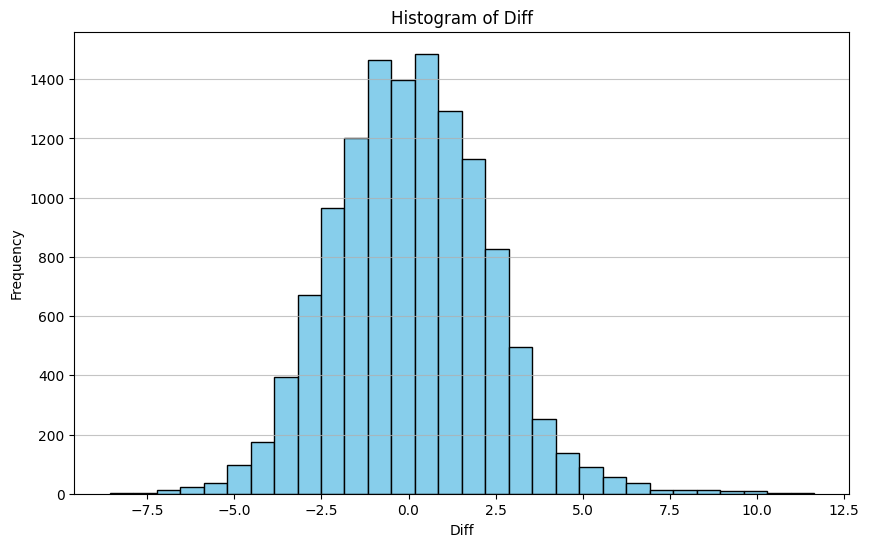

In [89]:
analyze_df_mins = mins_test_df.drop(['MP', 'MP_preds'], axis=1)\
                .merge(analyze_df_mins[['Date', 'Team', 'Player', 'MP', 'MP_preds']], on=['Date', 'Team', 'Player'])
analyze_df_mins['Diff'] = analyze_df_mins['MP'] - analyze_df_mins['MP_preds']
analyze_df_mins['Diff2'] = abs(analyze_df_mins['Diff'])
# display(analyze_df_mins.sort_values('Diff', ascending=True).drop('Diff2', axis=1).head(15))
display(analyze_df_mins[(analyze_df_mins.Early_Exit == 1) & (analyze_df_mins.MP_Decrease == 0)].sort_values('MP', ascending=True).head(10))

plt.figure(figsize=(10,6))
hist_col = 'Diff'
plt.hist(analyze_df_mins[hist_col], bins=30, color='skyblue', edgecolor='black')
plt.title(f'Histogram of {hist_col}')
plt.xlabel(hist_col)
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [13]:
# rmse = np.sqrt(mean_squared_error(y_test_mins, mins_preds)) # splits[5] = y_test
rmse = 5
mae = mean_absolute_error(y_test_mins, mins_preds)
print('RMSE:', rmse)
print('Spread rules: \n< 7 == 1\n7-12 == 2\n12 >= 3')

df_yesterday = pd.read_csv(f'../tables/2025/gmday_preds_{tgt_stat}.csv')
df_yesterday['Date'] = pd.to_datetime(df_yesterday.Date)
df_yesterday = df_yesterday[(df_yesterday.Date == (datetime.strptime(now, "%Y-%m-%d") - timedelta(days=1)).strftime("%Y-%m-%d"))]\
                .rename(columns={"MP": "MP_proj", "Spread": "Spread_Proj"})

df_gms = pd.read_csv(f"../tables/2025/season_gamelogs.csv")
df_gms['Date'] = pd.to_datetime(df_gms.Date)
df_gms = df_gms.merge(df_mtch, on=['Date', 'Team'])

df_yesterday = df_yesterday.merge(df_gms[['Date', 'Team', 'Player', 'MP', 'Spread']], on=['Date', 'Team', 'Player'])
df_yesterday['game_spread_type'] = 0
df_yesterday['game_spread_type'] = np.where(abs(df_yesterday.Spread) < 7, 1, df_yesterday.game_spread_type) 
df_yesterday['game_spread_type'] = np.where((abs(df_yesterday.Spread) >= 7) & (abs(df_yesterday.Spread) <= 12), 2, df_yesterday.game_spread_type) 
df_yesterday['game_spread_type'] = np.where(abs(df_yesterday.Spread) > 12, 3, df_yesterday.game_spread_type) 
df_yesterday['game_spread_type_proj'] = 0
df_yesterday['game_spread_type_proj'] = np.where(abs(df_yesterday.Spread_Proj) < 7, 1, df_yesterday.game_spread_type_proj) 
df_yesterday['game_spread_type_proj'] = np.where((abs(df_yesterday.Spread_Proj) >= 7) & (abs(df_yesterday.Spread_Proj) <= 12), 2, df_yesterday.game_spread_type_proj) 
df_yesterday['game_spread_type_proj'] = np.where(abs(df_yesterday.Spread_Proj) > 12, 3, df_yesterday.game_spread_type_proj) 
df_yesterday = df_yesterday[['Date', 'Team', 'Player', 'Pos', 'Opp', 'MP_proj', 'MP',  'game_spread_type', 'game_spread_type_proj']][df_yesterday.MP > 0]

df_yesterday['Diff'] = abs(df_yesterday['MP_proj'] - df_yesterday['MP'])
df_yesterday['InRMSE_Range'] = np.where(df_yesterday['Diff'] <= rmse, 1, 0)


print("\nYesterday's Results:")
print("Total Accuracy (InRMSE_Range):", ((df_yesterday.InRMSE_Range == 1).sum() / df_yesterday.shape[0]))
print((df_yesterday.InRMSE_Range == 1).sum(), '/', df_yesterday.shape[0])

df_yesterday = df_yesterday.drop(['Diff'], axis=1)

if df_yesterday.shape[0] >= 50:
    for tm in df_yesterday.Team.unique():
        display(df_yesterday[df_yesterday.Team == tm])
else:
    display(df_yesterday)

RMSE: 5
Spread rules: 
< 7 == 1
7-12 == 2
12 >= 3

Yesterday's Results:
Total Accuracy (InRMSE_Range): 0.704
88 / 125


,Date,Team,Player,Pos,Opp,MP_proj,MP,game_spread_type,game_spread_type_proj,InRMSE_Range
0,2026-01-09,GSW,Jimmy Butler,SF,SAC,22.542290,22.78,3,3,1
18,2026-01-09,GSW,De'Anthony Melton,PG,SAC,19.159517,18.70,3,3,1
19,2026-01-09,GSW,Brandin Podziemski,SG,SAC,20.837219,22.45,3,3,1
31,2026-01-09,GSW,Gary Payton II,SG,SAC,14.842323,17.93,3,3,1
47,2026-01-09,GSW,Moses Moody,SG,SAC,24.284437,21.72,3,3,1
48,2026-01-09,GSW,Stephen Curry,PG,SAC,30.981125,31.90,3,3,1
67,2026-01-09,GSW,Quinten Post,PF,SAC,21.869602,13.05,3,3,0
80,2026-01-09,GSW,Draymond Green,PF,SAC,24.200069,27.17,3,3,1
91,2026-01-09,GSW,Al Horford,C,SAC,16.550228,16.37,3,3,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,game_spread_type,game_spread_type_proj,InRMSE_Range
2,2026-01-09,DEN,Peyton Watson,SF,ATL,36.974709,34.00,3,1,1
12,2026-01-09,DEN,Aaron Gordon,PF,ATL,20.925768,24.47,3,1,1
27,2026-01-09,DEN,Tim Hardaway Jr.,SG,ATL,22.685877,26.07,3,1,1
29,2026-01-09,DEN,Christian Braun,SG,ATL,31.698648,24.78,3,1,0


,Date,Team,Player,Pos,Opp,MP_proj,MP,game_spread_type,game_spread_type_proj,InRMSE_Range
3,2026-01-09,OKC,Jalen Williams,SG,MEM,34.689350,36.27,1,1,1
4,2026-01-09,OKC,Aaron Wiggins,SG,MEM,29.524626,31.88,1,1,1
6,2026-01-09,OKC,Isaiah Joe,SG,MEM,19.053110,15.55,1,1,1
14,2026-01-09,OKC,Ajay Mitchell,SG,MEM,31.418369,38.02,1,1,0
41,2026-01-09,OKC,Kenrich Williams,PF,MEM,18.608213,28.90,1,1,0
78,2026-01-09,OKC,Alex Caruso,SG,MEM,19.104782,23.95,1,1,1
123,2026-01-09,OKC,Luguentz Dort,SF,MEM,30.736071,35.17,1,1,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,game_spread_type,game_spread_type_proj,InRMSE_Range
5,2026-01-09,NOP,Jordan Poole,PG,WAS,21.293865,11.73,3,1,0
8,2026-01-09,NOP,Zion Williamson,PF,WAS,27.269873,29.17,3,1,1
15,2026-01-09,NOP,Trey Murphy III,SF,WAS,34.612583,36.12,3,1,1
43,2026-01-09,NOP,Micah Peavy,SG,WAS,15.232307,27.68,3,1,0
57,2026-01-09,NOP,Jeremiah Fears,PG,WAS,25.753304,31.87,3,1,0
83,2026-01-09,NOP,Derik Queen,C,WAS,26.340851,34.68,3,1,0
127,2026-01-09,NOP,Yves Missi,C,WAS,16.573950,12.70,3,1,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,game_spread_type,game_spread_type_proj,InRMSE_Range
7,2026-01-09,PHI,VJ Edgecombe,SG,ORL,36.557617,39.53,2,1,1
37,2026-01-09,PHI,Tyrese Maxey,PG,ORL,37.461926,37.87,2,1,1
52,2026-01-09,PHI,Joel Embiid,C,ORL,31.692179,31.38,2,1,1
87,2026-01-09,PHI,Paul George,PF,ORL,32.326828,33.23,2,1,1
121,2026-01-09,PHI,Quentin Grimes,SG,ORL,22.156185,28.57,2,1,0
124,2026-01-09,PHI,Kelly Oubre Jr.,SF,ORL,21.288204,14.55,2,1,0


,Date,Team,Player,Pos,Opp,MP_proj,MP,game_spread_type,game_spread_type_proj,InRMSE_Range
9,2026-01-09,POR,Deni Avdija,SF,HOU,35.773636,35.82,1,2,1
17,2026-01-09,POR,Shaedon Sharpe,SG,HOU,29.269203,34.73,1,2,0
35,2026-01-09,POR,Toumani Camara,PF,HOU,33.654518,39.62,1,2,0
85,2026-01-09,POR,Donovan Clingan,C,HOU,28.962843,33.33,1,2,1
111,2026-01-09,POR,Robert Williams,C,HOU,14.569141,6.57,1,2,0


,Date,Team,Player,Pos,Opp,MP_proj,MP,game_spread_type,game_spread_type_proj,InRMSE_Range
10,2026-01-09,NYK,Karl-Anthony Towns,C,PHO,26.952854,32.97,1,1,0
58,2026-01-09,NYK,Miles McBride,SG,PHO,27.302473,39.48,1,1,0
66,2026-01-09,NYK,Mitchell Robinson,C,PHO,19.542173,24.02,1,1,1
68,2026-01-09,NYK,Mikal Bridges,SF,PHO,34.071651,32.52,1,1,1
82,2026-01-09,NYK,Jordan Clarkson,SG,PHO,18.802923,20.52,1,1,1
92,2026-01-09,NYK,OG Anunoby,PF,PHO,32.946823,37.87,1,1,1
106,2026-01-09,NYK,Jalen Brunson,PG,PHO,34.644009,37.03,1,1,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,game_spread_type,game_spread_type_proj,InRMSE_Range
11,2026-01-09,MIL,Giannis Antetokounmpo,PF,LAL,25.982786,30.80,1,1,1
63,2026-01-09,MIL,Kyle Kuzma,PF,LAL,20.989973,22.98,1,1,1
69,2026-01-09,MIL,Bobby Portis,PF,LAL,21.027567,30.03,1,1,0
74,2026-01-09,MIL,Ryan Rollins,PG,LAL,30.727169,30.98,1,1,1
104,2026-01-09,MIL,Kevin Porter Jr.,PG,LAL,36.687820,39.48,1,1,1
105,2026-01-09,MIL,Myles Turner,C,LAL,27.709188,22.95,1,1,1
110,2026-01-09,MIL,Gary Trent Jr.,SG,LAL,17.954441,19.17,1,1,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,game_spread_type,game_spread_type_proj,InRMSE_Range
13,2026-01-09,LAC,Ivica Zubac,C,BRK,25.901554,24.92,3,1,1
21,2026-01-09,LAC,James Harden,PG,BRK,33.907070,34.52,3,1,1
55,2026-01-09,LAC,Kawhi Leonard,SF,BRK,34.843346,28.37,3,1,0
73,2026-01-09,LAC,John Collins,PF,BRK,27.632879,26.23,3,1,1
88,2026-01-09,LAC,Brook Lopez,C,BRK,19.094229,20.65,3,1,1
114,2026-01-09,LAC,Nicolas Batum,PF,BRK,19.927301,22.87,3,1,1
115,2026-01-09,LAC,Kris Dunn,PG,BRK,27.901823,22.18,3,1,0


,Date,Team,Player,Pos,Opp,MP_proj,MP,game_spread_type,game_spread_type_proj,InRMSE_Range
16,2026-01-09,MEM,Santi Aldama,PF,OKC,21.382238,28.78,1,1,0
40,2026-01-09,MEM,Cedric Coward,SG,OKC,24.302820,25.50,1,1,1
44,2026-01-09,MEM,Cam Spencer,SG,OKC,27.431128,30.10,1,1,1
46,2026-01-09,MEM,Jaren Jackson Jr.,C,OKC,31.358377,32.35,1,1,1
64,2026-01-09,MEM,Jaylen Wells,SG,OKC,27.950611,27.87,1,1,1
116,2026-01-09,MEM,Jock Landale,C,OKC,23.729094,28.25,1,1,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,game_spread_type,game_spread_type_proj,InRMSE_Range
22,2026-01-09,ORL,Anthony Black,PG,PHI,30.866930,37.33,2,1,0
79,2026-01-09,ORL,Goga Bitadze,C,PHI,16.394186,11.87,2,1,1
89,2026-01-09,ORL,Jase Richardson,SG,PHI,15.738738,18.55,2,1,1
93,2026-01-09,ORL,Desmond Bane,SG,PHI,32.163277,37.78,2,1,0
112,2026-01-09,ORL,Wendell Carter Jr.,C,PHI,29.334953,28.88,2,1,1
119,2026-01-09,ORL,Paolo Banchero,PF,PHI,33.807343,37.40,2,1,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,game_spread_type,game_spread_type_proj,InRMSE_Range
23,2026-01-09,WAS,Tre Johnson,SG,NOP,25.513710,25.23,3,1,1
98,2026-01-09,WAS,Bilal Coulibaly,SG,NOP,26.887815,29.50,3,1,1
99,2026-01-09,WAS,Khris Middleton,SF,NOP,24.335001,20.88,3,1,1
103,2026-01-09,WAS,Justin Champagnie,SF,NOP,20.166208,21.63,3,1,1
108,2026-01-09,WAS,Kyshawn George,SF,NOP,30.831886,23.63,3,1,0


,Date,Team,Player,Pos,Opp,MP_proj,MP,game_spread_type,game_spread_type_proj,InRMSE_Range
25,2026-01-09,HOU,Tari Eason,PF,POR,26.212294,15.53,1,2,0
32,2026-01-09,HOU,Reed Sheppard,PG,POR,20.933252,33.58,1,2,0
56,2026-01-09,HOU,Jabari Smith Jr.,PF,POR,33.611439,40.65,1,2,0
60,2026-01-09,HOU,Kevin Durant,SF,POR,35.205109,39.35,1,2,1
100,2026-01-09,HOU,Steven Adams,C,POR,23.906372,32.70,1,2,0
120,2026-01-09,HOU,Amen Thompson,SF,POR,35.266922,36.95,1,2,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,game_spread_type,game_spread_type_proj,InRMSE_Range
26,2026-01-09,LAL,Jake LaRavia,PF,MIL,31.468588,34.42,1,1,1
36,2026-01-09,LAL,LeBron James,SF,MIL,31.565365,32.85,1,1,1
95,2026-01-09,LAL,Marcus Smart,SG,MIL,29.366116,30.18,1,1,1
97,2026-01-09,LAL,Jaxson Hayes,C,MIL,17.063293,24.45,1,1,0
107,2026-01-09,LAL,Jarred Vanderbilt,PF,MIL,20.313051,26.53,1,1,0
113,2026-01-09,LAL,Luka Doncic,PG,MIL,34.526794,36.08,1,1,1
117,2026-01-09,LAL,Deandre Ayton,C,MIL,28.395054,23.55,1,1,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,game_spread_type,game_spread_type_proj,InRMSE_Range
28,2026-01-09,SAC,Maxime Raynaud,C,GSW,28.416058,26.30,3,3,1
34,2026-01-09,SAC,DeMar DeRozan,PF,GSW,31.237789,34.87,3,3,1
38,2026-01-09,SAC,Russell Westbrook,PG,GSW,27.759083,28.22,3,3,1
51,2026-01-09,SAC,Zach LaVine,SG,GSW,30.723394,30.47,3,3,1
77,2026-01-09,SAC,Precious Achiuwa,C,GSW,17.803028,4.55,3,3,0
90,2026-01-09,SAC,Dennis Schroder,PG,GSW,21.022306,20.45,3,3,1
101,2026-01-09,SAC,Nique Clifford,SG,GSW,19.765305,24.87,3,3,0


,Date,Team,Player,Pos,Opp,MP_proj,MP,game_spread_type,game_spread_type_proj,InRMSE_Range
30,2026-01-09,PHO,Mark Williams,C,NYK,23.321787,24.83,1,1,1
39,2026-01-09,PHO,Devin Booker,SG,NYK,31.577562,38.52,1,1,0
50,2026-01-09,PHO,Dillon Brooks,SF,NYK,29.275494,32.95,1,1,1
53,2026-01-09,PHO,Jordan Goodwin,PG,NYK,20.501417,17.52,1,1,1
76,2026-01-09,PHO,Collin Gillespie,PG,NYK,27.591234,27.98,1,1,1
81,2026-01-09,PHO,Grayson Allen,SG,NYK,20.879576,25.87,1,1,1
96,2026-01-09,PHO,Royce O'Neale,SF,NYK,27.782864,33.25,1,1,0
126,2026-01-09,PHO,Oso Ighodaro,PF,NYK,20.299540,23.03,1,1,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,game_spread_type,game_spread_type_proj,InRMSE_Range
33,2026-01-09,TOR,Ja'Kobe Walter,SG,BOS,28.468546,31.43,2,2,1
42,2026-01-09,TOR,Jamal Shead,PG,BOS,19.827618,24.03,2,2,1
70,2026-01-09,TOR,Immanuel Quickley,PG,BOS,34.438999,34.80,2,2,1
109,2026-01-09,TOR,Sandro Mamukelashvili,C,BOS,30.010509,24.92,2,2,0
122,2026-01-09,TOR,Collin Murray-Boyles,PF,BOS,30.914680,21.12,2,2,0
129,2026-01-09,TOR,RJ Barrett,SF,BOS,32.556210,27.88,2,2,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,game_spread_type,game_spread_type_proj,InRMSE_Range
49,2026-01-09,BOS,Jaylen Brown,SF,TOR,30.032644,36.52,2,2,0
62,2026-01-09,BOS,Anfernee Simons,SG,TOR,20.448523,26.32,2,2,0
65,2026-01-09,BOS,Sam Hauser,PF,TOR,23.986425,31.57,2,2,0
71,2026-01-09,BOS,Derrick White,SG,TOR,34.454891,37.97,2,2,1
84,2026-01-09,BOS,Payton Pritchard,PG,TOR,33.048523,29.67,2,2,1
94,2026-01-09,BOS,Luka Garza,C,TOR,18.013474,20.70,2,2,1
128,2026-01-09,BOS,Neemias Queta,C,TOR,25.010262,27.18,2,2,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,game_spread_type,game_spread_type_proj,InRMSE_Range
54,2026-01-09,ATL,Dyson Daniels,SG,DEN,33.855453,35.63,3,1,1
72,2026-01-09,ATL,Jalen Johnson,SF,DEN,34.870808,34.72,3,1,1
75,2026-01-09,ATL,Onyeka Okongwu,C,DEN,32.192303,34.72,3,1,1
118,2026-01-09,ATL,Nickeil Alexander-Walker,SG,DEN,32.007828,33.37,3,1,1
125,2026-01-09,ATL,Vit Krejci,PG,DEN,25.342039,27.33,3,1,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,game_spread_type,game_spread_type_proj,InRMSE_Range
61,2026-01-09,BRK,Michael Porter Jr.,SF,LAC,32.535412,33.43,3,1,1
86,2026-01-09,BRK,Day'Ron Sharpe,C,LAC,19.241596,17.05,3,1,1
102,2026-01-09,BRK,Noah Clowney,PF,LAC,27.360868,30.08,3,1,1


# Main Model

In [132]:
def setup_df_main(df, tgt_stat):
    
    df = df[['Season', 'Date', 'Team', 'Opp', 'Player', 'Pos', 'role', 'MP', 'team_game_num', 
             'PTS', 'FG', 'FGA', 'FG%', 'TPA', 'TPM', 'TP%', 'FT', 'FTA', 'FT%', 
             'MP_h1', 'MP_h2', 'MP_q1', 'MP_q2', 'MP_q3', 'MP_q4', 
             f'Off_{tgt_stat}', f'Off_L3_{tgt_stat}', f'Off_L5_{tgt_stat}', f'Off_L10_{tgt_stat}', f'Off_{tgt_stat}_Rk',
             f'Def_{tgt_stat}', f'Def_L3_{tgt_stat}', f'Def_L5_{tgt_stat}', f'Def_L10_{tgt_stat}', f'Def_{tgt_stat}_Rk',
             'Spread', 'Total', 'is_OT']]
    df['dataset_gm'] = (df.groupby('Player')['MP'].cumcount().add(1).reset_index(drop=True))
    
    # Create rolling + lag features    
    for col in ['MP', 'FG', 'FGA', 'FT', 'FTA', 'TPM', 'TPA']:
        for N in [3, 5, 10]:
            df[f'{col}_L{N}_avg'] = (
                df.groupby(['Player', 'Season'])[col]
                  .rolling(window=N, min_periods=1)
                  .mean()
                  .shift(1)
                  .reset_index(level=[0, 1], drop=True)
            )
            
    for N in [1, 3, 5]:
        df[f"recent_role_L{N}"] = (
            df
            .groupby(["Player", "Season"])["role"]
            .rolling(5, min_periods=1)
            .apply(lambda arr: np.bincount(arr.astype(int), minlength=4).argmax(), raw=True)
            .reset_index(level=[0, 1], drop=True)
        )

    df['OT_adj_MP'] = np.where(df.is_OT != 0, df.MP - (5 * df.is_OT), df.MP)
    df['role'] = np.where(((df.OT_adj_MP >= 24) & (df.role != 1)), 1, df.role)
    df['role'] = np.where(((df.OT_adj_MP < 24) & (df.role == 1)), 2, df.role)
    df['role'] = np.where(((df.OT_adj_MP < 14) & (df.role == 2)), 3, df.role)
    for N in [1, 3, 5]:
        df[f"recent_role_L{N}"] = (
            df
            .groupby(["Player", "Season"])["role"]
            .rolling(5, min_periods=1)
            .apply(lambda arr: np.bincount(arr.astype(int), minlength=4).argmax(), raw=True)
            .reset_index(level=[0, 1], drop=True)
        )
    
    df['game_spread_type'] = 0
    df['game_spread_type'] = np.where(abs(df.Spread) < 7, 1, df.game_spread_type) 
    df['game_spread_type'] = np.where((abs(df.Spread) >= 7) & (abs(df.Spread) <= 12), 2, df.game_spread_type) 
    df['game_spread_type'] = np.where(abs(df.Spread) > 12, 3, df.game_spread_type) 
    df['game_spread_type'] = np.where(df.is_OT > 0, 1, df.game_spread_type) 
    
    df['TeamPTS'] = (df.Total + (df.Spread * -1)) / 2
    df['TeamPTS_type'] = 0
    df['TeamPTS_type'] = np.where((df.TeamPTS > 104) & (df.TeamPTS <= 116), 1, df.TeamPTS_type)
    df['TeamPTS_type'] = np.where((df.TeamPTS > 116) & (df.TeamPTS <= 126), 2, df.TeamPTS_type)
    df['TeamPTS_type'] = np.where((df.TeamPTS > 126), 3, df.TeamPTS_type)
    
    df2 = create_df_missing(df, 'MP')
    df = df.merge(df2, on=["Season", "Date", "Team"], how='left')
    df['starters_out'] = df.starters_out.fillna(0)
    df['starters_out_L1'] = (
        df.groupby(['Player', 'Season'])['starters_out']
          .rolling(window=1, min_periods=1)
          .mean()
          .shift(1)
          .reset_index(level=[0, 1], drop=True)
    )
    df['starters_returning'] = np.where(df['starters_out_L1'] > df['starters_out'], df['starters_out_L1'] - df['starters_out'], 0)
    
    df['MP_change_pct_L10'] = (df['MP'] - df['MP_L10_avg']) / df['MP_L10_avg']
    MP_Decrease_conds = (
        ((df.role == 1) & (df['MP_change_pct_L10'] <= -0.25)) | 
        ((df.role == 2) & (df['MP_change_pct_L10'] <= -0.35)) | 
        ((df.role == 3) & (df['MP_change_pct_L10'] <= -0.45)) | 
        ((df.role != 3) & (df['MP'] < 8)) | 
        ((df.role == 1) & (df.MP_q4 == 0))
    )
    df['MP_Decrease'] = np.where(MP_Decrease_conds, 1, 0)

    # Tell model games exist after players injuries/susp
    team_games = df[['Season', 'Team', 'Date', 'team_game_num']].drop_duplicates()
    players = df[['Season','Player','Team']].drop_duplicates()
    fabricated = (players.sort_values('Season').groupby('Player', as_index=False).last())
    fabricated['Season'] = fabricated['Season'] + 1
    players = pd.concat([players, fabricated], ignore_index=True).drop_duplicates(['Season','Player','Team'])
    expanded = team_games.merge(players, on=['Season', 'Team'], how='left')
    expanded = expanded.merge(df[['Season', 'Player', 'Date', 'MP']], on=['Season', 'Player', 'Date'], how='left').drop_duplicates(['Season', 'Date', 'Player', 'Team'])
    expanded['player_played'] = expanded['MP'].notna().astype(int)
    expanded['team_played_no_player'] = ((expanded['player_played'] == 0)).astype(int)
    expanded['tm_plays_after'] = (expanded.groupby(['Player'])['team_played_no_player'].shift(-1))
    expanded['missed_gms_aftr'] = 0
    expanded['missed_gms_aftr'] = np.where((expanded.player_played == 1) & (expanded.tm_plays_after == 1), 1, expanded.missed_gms_aftr)
    df = df.merge(expanded[['Date', 'Team', 'Player', 'missed_gms_aftr']], on=['Date', 'Team', 'Player'])
    
    df['missed_games'] = (df.groupby(['Player', 'Team', 'Season'])['team_game_num'].diff().sub(1).fillna(0).astype(int))
    df['Injured'] = ((df.MP_Decrease == 1) & (df.missed_gms_aftr > 0) | (df.missed_games > 1)).astype(int)
    df['return_game'] = ((df.groupby('Player')['Injured'].shift(1) == 1) & (df.missed_games > 0)).astype(int)
    df['games_since_return'] = (df.groupby('Player')['return_game'].cumsum())
    df['games_since_return'] = (df.groupby(['Player', 'games_since_return']).cumcount())
    df['ramp_phase'] = 0
    df.loc[df.return_game == 1, 'ramp_phase'] = 1
    df.loc[(df.games_since_return.isin([1, 2, 3]) & (df.dataset_gm > 4)), 'ramp_phase'] = 2
    df.loc[df.games_since_return >= 4, 'ramp_phase'] = 0
    
    df['PTS_change_pct_L10'] = (df['PTS'] - df[f'Off_L10_{tgt_stat}']) / df[f'Off_L10_{tgt_stat}']
    Overperformed_conds = (
                    ((df.role == 1) & (df['PTS_change_pct_L10'] >= 0.05)) | 
                    ((df.role == 2) & (df['PTS_change_pct_L10'] >= 0.10)) | 
                    ((df.role == 3) & (df['PTS_change_pct_L10'] >= 0.15)) 
                   )
    df['Overperformed'] = np.where(Overperformed_conds, 1, 0)
    Underperformed_conds = (
        ((df.role == 1) & (df['PTS_change_pct_L10'] <= -0.25)) | 
        ((df.role == 2) & (df['PTS_change_pct_L10'] <= -0.35)) | 
        ((df.role == 3) & (df['PTS_change_pct_L10'] <= -0.45)) 
    )
    df['Underperformed'] = np.where(Underperformed_conds, 1, 0)
    
    df = df.drop(['Season', 'team_game_num', 'FG', 'FGA', 'FG%', 'TPA', 'TPM', 'TP%', 'FT', 'FTA', 'FT%', 
                 'MP_h1', 'MP_h2', 'MP_q1', 'MP_q2', 'MP_q3', 'MP_q4', 
                 'OT_adj_MP', 'MP_change_pct_L10', 'MP_Decrease', 'starters_out_L1', 
                 'games_since_return', 'return_game', 'missed_gms_aftr', 'dataset_gm', 
                 'PTS_change_pct_L10', 'Spread', 'Total', 'TeamPTS'], axis=1)
        
    return df

,Date,Team,Opp,Player,Pos,role,MP,PTS,Off_PTS,Off_L3_PTS,Off_L5_PTS,Off_L10_PTS,Off_PTS_Rk,Def_PTS,Def_L3_PTS,Def_L5_PTS,Def_L10_PTS,Def_PTS_Rk,is_OT,MP_L3_avg,MP_L5_avg,MP_L10_avg,FG_L3_avg,FG_L5_avg,FG_L10_avg,FGA_L3_avg,FGA_L5_avg,FGA_L10_avg,FT_L3_avg,FT_L5_avg,FT_L10_avg,FTA_L3_avg,FTA_L5_avg,FTA_L10_avg,TPM_L3_avg,TPM_L5_avg,TPM_L10_avg,TPA_L3_avg,TPA_L5_avg,TPA_L10_avg,recent_role_L1,recent_role_L3,recent_role_L5,game_spread_type,TeamPTS_type,starters_out,starters_returning,missed_games,Injured,ramp_phase,Overperformed,Underperformed
0,2021-10-19,2,16,81,0,2,22.98,6.0,6.000000,6.000000,6.0,6.0,7.0,18.000000,18.000000,18.0,18.0,3.0,0,2.226667,3.750,5.966000,0.333333,0.6,0.400000,0.666667,0.8,0.600000,0.000000,0.2,0.100000,0.000000,0.4,0.200000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,2.0,2.0,2.0,3,0,0.0,0.0,0,0,0,0,0
1,2021-10-19,2,16,110,3,3,3.75,0.0,0.000000,0.000000,0.0,0.0,7.0,9.000000,9.000000,9.0,9.0,2.0,0,7.330000,7.330,7.330000,0.000000,0.0,0.000000,1.000000,1.0,1.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,1.000000,1.0,1.000000,3.0,3.0,3.0,3,0,0.0,0.0,0,1,0,0,0
2,2021-10-19,2,16,129,4,3,3.75,2.0,2.000000,2.000000,2.0,2.0,6.0,21.000000,21.000000,21.0,21.0,3.0,0,29.133333,27.612,27.590000,5.000000,3.6,3.600000,11.333333,9.4,8.600000,1.333333,1.4,2.100000,1.666667,1.6,2.300000,2.666667,1.8,1.800000,6.000000,5.0,4.800000,3.0,3.0,3.0,3,0,0.0,0.0,0,1,0,0,0
3,2021-10-19,2,16,244,3,3,3.75,0.0,0.000000,0.000000,0.0,0.0,7.0,9.000000,9.000000,9.0,9.0,2.0,0,11.650000,11.650,11.650000,2.000000,2.0,2.000000,2.500000,2.5,2.500000,0.500000,0.5,0.500000,1.000000,1.0,1.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,3.0,3.0,3.0,3,0,0.0,0.0,0,0,0,0,0
4,2021-10-19,2,16,457,2,1,30.63,20.0,20.000000,20.000000,20.0,20.0,2.0,20.000000,20.000000,20.0,20.0,3.0,0,4.620000,8.382,7.942857,0.666667,1.8,1.571429,2.000000,3.4,3.428571,0.000000,0.8,0.571429,0.333333,1.0,0.714286,0.000000,0.4,0.428571,0.666667,1.2,1.142857,1.0,1.0,1.0,3,0,0.0,1.0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123062,2026-01-09,29,18,633,3,2,20.88,4.0,9.791667,10.000000,8.0,9.9,41.0,25.483871,28.000000,28.4,25.2,9.0,0,21.076667,21.692,22.836000,3.000000,2.2,3.300000,7.333333,7.0,8.300000,3.000000,3.0,2.500000,3.333333,3.2,2.900000,1.000000,0.6,0.800000,3.666667,2.4,2.600000,2.0,2.0,2.0,3,1,0.0,0.0,1,0,0,0,1
123063,2026-01-09,29,18,656,3,2,23.63,15.0,15.000000,13.000000,15.6,14.3,24.0,25.483871,28.000000,28.4,25.2,9.0,0,31.030000,33.680,32.860000,5.333333,6.2,5.300000,11.666667,12.8,11.400000,1.333333,2.0,1.800000,2.000000,2.6,2.400000,1.000000,1.2,1.900000,4.333333,4.8,5.400000,1.0,1.0,1.0,3,1,0.0,0.0,7,1,0,0,0
123064,2026-01-09,29,18,691,4,2,23.72,10.0,3.800000,4.000000,4.4,3.8,97.0,34.394737,36.000000,37.8,34.5,30.0,0,13.746667,14.382,11.100000,1.333333,1.6,1.400000,4.000000,4.0,3.400000,1.000000,1.0,0.700000,1.333333,1.2,0.800000,0.333333,0.2,0.300000,1.333333,1.2,1.100000,2.0,2.0,2.0,3,1,0.0,0.0,0,0,0,1,0
123065,2026-01-09,29,18,975,4,1,25.23,12.0,12.275862,13.000000,13.0,14.6,33.0,34.394737,36.000000,37.8,34.5,30.0,0,25.830000,26.772,25.100000,4.333333,4.6,5.200000,10.333333,10.2,10.400000,3.333333,2.0,2.100000,3.333333,2.0,2.100000,1.000000,1.8,2.100000,5.000000,5.0,5.100000,1.0,1.0,1.0,3,1,0.0,0.0,0,0,0,0,0



Trial 1/10: {'n_estimators': 472, 'learning_rate': np.float64(0.02770890529607336), 'max_depth': 5, 'min_child_weight': 7, 'subsample': np.float64(0.8459548462173294), 'colsample_bytree': np.float64(0.8093907527473195), 'gamma': np.float64(0.3084065566439653), 'reg_lambda': np.float64(4.97470050910355), 'reg_alpha': np.float64(1.7371604834817655)}
Validation MAE: 1.5030

Trial 2/10: {'n_estimators': 1201, 'learning_rate': np.float64(0.019104073213577235), 'max_depth': 3, 'min_child_weight': 5, 'subsample': np.float64(0.759876776025105), 'colsample_bytree': np.float64(0.7567194205122137), 'gamma': np.float64(0.45028881984279745), 'reg_lambda': np.float64(2.253987694603066), 'reg_alpha': np.float64(0.1165678235658274)}
Validation MAE: 1.5945

Trial 3/10: {'n_estimators': 1194, 'learning_rate': np.float64(0.010709452570023172), 'max_depth': 5, 'min_child_weight': 5, 'subsample': np.float64(0.8366671468539234), 'colsample_bytree': np.float64(0.7587784914444453), 'gamma': np.float64(1.0206

,feature,importance,pct
0,Underperformed,11006.833008,0.229207
1,Off_L3_PTS,10605.698242,0.450062
2,Overperformed,5965.730957,0.574293
3,Off_L10_PTS,4868.727051,0.675680
4,MP,4044.636719,0.759906
5,role,3639.909180,0.835703
6,Off_L5_PTS,3409.670166,0.906707
7,TeamPTS_type,423.391083,0.915523
8,recent_role_L3,396.044403,0.923771
9,Off_PTS,317.186432,0.930376


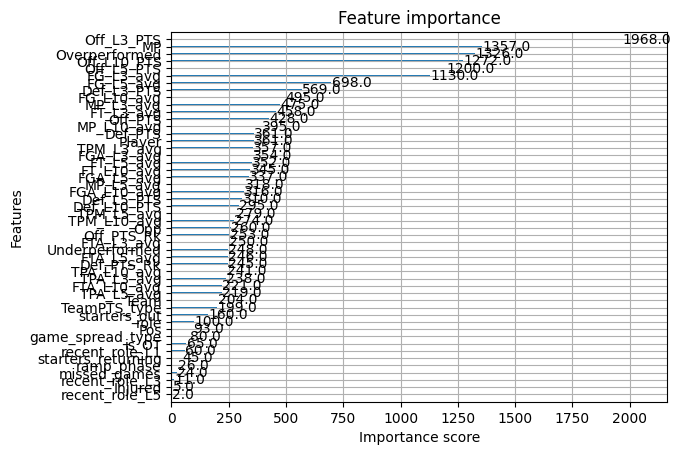

Saved PTS model!


In [133]:
df_main = df.copy()
df_main = setup_df_main(df_main, tgt_stat)
display(df_main)

n = len(df_main)
train_end = int(0.65 * n)
val_end   = int(0.85 * n)
main_train_df = df_main.iloc[:train_end]
main_val_df   = df_main.iloc[train_end:val_end]
main_test_df  = df_main.iloc[val_end:]
main_DFS = (main_train_df, main_val_df, main_test_df)

# stat_model = create_baseline_model(df_main, tgt_stat, main_DFS)
stat_model, stat_preds, y_test_stat, analyze_df_stat = hyperparam_tuning(main_DFS, tgt_stat, n_iter=10)
feature_importance(stat_model, df_main.columns.tolist())

stat_model.save_model(f"../ML_models/{tgt_stat}_model.json")
print(f'Saved {tgt_stat} model!')

,Date,Team,Opp,Player,Pos,role,MP,Off_PTS,Off_L3_PTS,Off_L5_PTS,Off_L10_PTS,Off_PTS_Rk,Def_PTS,Def_L3_PTS,Def_L5_PTS,Def_L10_PTS,Def_PTS_Rk,is_OT,MP_L3_avg,MP_L5_avg,MP_L10_avg,FG_L3_avg,FG_L5_avg,FG_L10_avg,FGA_L3_avg,FGA_L5_avg,FGA_L10_avg,FT_L3_avg,FT_L5_avg,FT_L10_avg,FTA_L3_avg,FTA_L5_avg,FTA_L10_avg,TPM_L3_avg,TPM_L5_avg,TPM_L10_avg,TPA_L3_avg,TPA_L5_avg,TPA_L10_avg,recent_role_L1,recent_role_L3,recent_role_L5,game_spread_type,TeamPTS_type,starters_out,starters_returning,missed_games,Injured,ramp_phase,Overperformed,Underperformed,PTS,PTS_preds,Diff
12810,2025-11-28,LAL,DAL,Luka Doncic,PG,1,40.30,35.142857,37.000000,37.8,32.7,1.0,21.733333,25.000000,30.6,23.9,7.0,0,37.556667,38.222,36.895,11.666667,10.0,9.6,24.666667,21.8,22.3,10.333333,11.6,9.4,13.000000,14.4,11.9,4.000000,4.0,3.5,11.333333,10.6,10.7,1.0,1.0,1.0,2,3,0.0,0.0,0,0,0,1,0,35.0,47.647961,-12.647961
1245,2025-03-20,SAC,CHI,Zach LaVine,SG,1,32.85,23.976190,23.333333,26.4,26.0,3.0,22.290909,15.666667,13.6,17.1,25.0,0,35.156667,37.108,36.927,6.333333,7.2,8.2,10.000000,12.4,14.6,3.000000,3.8,2.7,3.666667,4.2,3.1,3.666667,2.8,3.4,6.000000,5.8,6.5,1.0,1.0,1.0,2,1,2.0,0.0,1,0,0,0,1,8.0,17.978333,-9.978333
18334,2026-01-09,LAL,MIL,Luka Doncic,PG,1,36.08,33.678571,34.666667,33.6,31.3,1.0,23.114286,33.000000,29.0,24.3,7.0,0,38.230000,37.594,35.194,11.333333,10.2,9.6,22.666667,21.6,21.4,9.000000,10.6,9.3,12.666667,14.2,12.1,3.000000,2.6,2.8,9.666667,9.4,10.1,1.0,1.0,1.0,1,0,0.0,0.0,0,0,0,0,0,24.0,33.350079,-9.350079
4759,2025-04-11,HOU,LAL,Reed Sheppard,PG,1,41.13,4.490196,11.333333,9.8,8.8,79.0,19.537500,24.000000,25.6,25.1,3.0,0,12.933333,11.956,13.162,2.333333,2.8,2.8,5.000000,5.0,5.7,0.000000,0.0,0.4,0.000000,0.0,0.6,2.000000,2.6,1.7,3.666667,4.2,3.3,3.0,3.0,3.0,3,1,6.0,0.0,0,0,0,1,0,14.0,23.154110,-9.154110
15492,2025-12-20,UTA,ORL,Keyonte George,PG,1,41.55,24.000000,32.666667,29.0,25.1,9.0,26.500000,39.000000,31.6,30.0,26.0,1,37.910000,33.876,33.038,10.666667,8.0,7.6,20.000000,16.8,16.0,10.333333,8.0,7.0,11.333333,8.6,8.0,5.000000,3.2,3.0,10.000000,7.4,6.8,1.0,1.0,1.0,1,3,0.0,0.0,0,0,0,1,0,27.0,35.974480,-8.974480
6044,2025-04-28,MIA,CLE,Tyler Herro,SG,1,30.52,23.843373,16.666667,20.2,24.6,6.0,26.630952,20.666667,19.6,25.1,7.0,0,37.833333,38.930,35.964,8.666667,9.8,9.6,18.333333,19.0,18.6,2.333333,4.2,4.7,2.666667,4.8,5.2,2.666667,3.2,2.8,6.666667,7.4,6.4,1.0,1.0,1.0,3,0,1.0,0.0,0,1,0,0,1,4.0,12.921535,-8.921535
3914,2025-04-06,GSW,HOU,Stephen Curry,PG,1,32.67,24.439394,25.333333,28.2,24.0,10.0,25.013889,20.333333,20.8,24.1,30.0,0,34.323333,32.534,32.271,13.000000,10.0,8.0,25.333333,21.4,17.9,8.000000,6.2,5.4,8.333333,6.6,5.9,7.666667,6.0,4.7,15.333333,13.2,11.4,1.0,1.0,1.0,2,0,2.0,0.0,0,0,0,0,1,3.0,11.569177,-8.569177
17506,2026-01-03,POR,SAS,Shaedon Sharpe,SG,1,28.32,21.838710,20.333333,20.6,23.4,7.0,29.032258,25.000000,25.4,28.6,23.0,0,30.840000,31.304,31.979,7.666667,8.0,9.2,19.333333,19.4,19.5,4.000000,2.6,2.6,4.000000,2.8,3.3,1.000000,2.0,2.4,4.333333,5.4,5.7,1.0,1.0,1.0,1,1,0.0,0.0,0,0,0,0,1,6.0,14.398556,-8.398556
18418,2026-01-09,POR,HOU,Caleb Love,SG,1,24.58,10.066667,13.333333,14.4,15.0,45.0,21.000000,27.000000,24.4,21.9,1.0,0,7.793333,9.450,16.659,0.333333,0.4,1.5,2.333333,2.8,4.0,0.000000,0.0,0.2,0.000000,0.0,0.3,0.333333,0.4,0.9,2.000000,2.0,2.7,1.0,1.0,1.0,1,1,0.0,0.0,0,0,0,1,0,18.0,26.275085,-8.275085
13226,2025-11-30,UTA,HOU,Keyonte George,PG,2,19.13,22.526316,19.666667,21.2,22.9,10.0,17.176471,15.000000,17.4,15.8,1.0,0,37.473333,35.620,34.797,10.000000,9.8,8.5,19.666667,18.4,18.2,4.666667,4.8,4.8,6.666667,6.0,5.4,4.000000,3.6,2.9,9.000000,8.4,7.9,1.0,1.0,1.0,3,0,0.0,0.0,0,0,0,0,1,0.0,8.074669,-8.074669


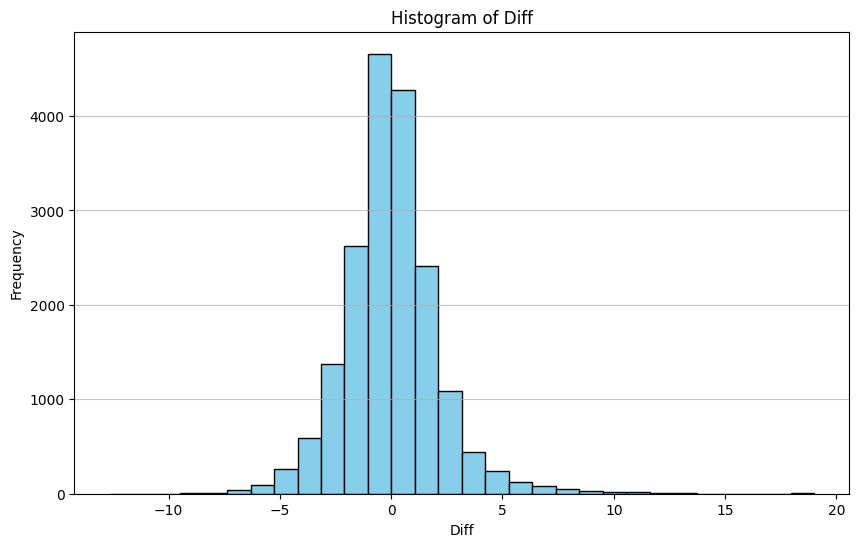

In [139]:
analyze_df_stat = main_test_df.drop([tgt_stat, f'{tgt_stat}_preds'], axis=1)\
                .merge(analyze_df_stat[['Date', 'Team', 'Player', tgt_stat, f'{tgt_stat}_preds']], on=['Date', 'Team', 'Player'])
analyze_df_stat['Diff'] = analyze_df_stat[tgt_stat] - analyze_df_stat[f'{tgt_stat}_preds']
analyze_df_stat['Diff2'] = abs(analyze_df_stat['Diff'])
display(analyze_df_stat.sort_values('Diff', ascending=True).drop('Diff2', axis=1).head(15))
# display(analyze_df_stat[(analyze_df_stat.Date == '2026-01-04') & (analyze_df_stat.Team == 'LAL')])

plt.figure(figsize=(10,6))
hist_col = 'Diff'
plt.hist(analyze_df_stat[hist_col], bins=30, color='skyblue', edgecolor='black')
plt.title(f'Histogram of {hist_col}')
plt.xlabel(hist_col)
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [18]:
rmse = np.sqrt(mean_squared_error(y_test_stat, stat_preds)) # splits[5] = y_test
mae = mean_absolute_error(y_test_stat, stat_preds)
print('RMSE:', rmse)

df_yesterday = pd.read_csv(f'../tables/2025/gmday_preds_{tgt_stat}.csv')
df_yesterday['Date'] = pd.to_datetime(df_yesterday.Date)
df_yesterday = df_yesterday[(df_yesterday.Date == (datetime.strptime(now, "%Y-%m-%d") - timedelta(days=1)).strftime("%Y-%m-%d"))]\
                .rename(columns={"MP": "MP_proj"})

df_gms = pd.read_csv(f"../tables/2025/season_gamelogs.csv")
df_gms['Date'] = pd.to_datetime(df_gms.Date)
df_gms = df_gms.rename(columns={"TRB": "REB", "3PM": "TPM", "3PA": "TPA"})
df_gms['STL_BLK'] = df_gms.STL + df_gms.BLK
df_gms['PR'] = df_gms.PTS + df_gms.REB 
df_gms['PA'] = df_gms.PTS + df_gms.AST
df_gms['RA'] = df_gms.REB + df_gms.AST
df_gms['PRA'] = df_gms.PTS + df_gms.REB + df_gms.AST

df_yesterday = df_yesterday.merge(df_gms[['Date', 'Team', 'Player', tgt_stat, 'MP']], on=['Date', 'Team', 'Player'])
df_yesterday = df_yesterday[['Date', 'Team', 'Player', 'Pos', 'Opp', 'MP_proj', 'MP', f'{tgt_stat}_line', f'{tgt_stat}_proj', tgt_stat]][df_yesterday.MP > 0]

df_yesterday['Diff'] = df_yesterday[f'{tgt_stat}_proj'] - df_yesterday[f'{tgt_stat}_line']
df_yesterday['Diff2'] = abs(df_yesterday[f'{tgt_stat}_proj'] - df_yesterday[tgt_stat])
df_yesterday['Act_Res'] = np.where(df_yesterday[tgt_stat] > df_yesterday[f'{tgt_stat}_line'], 'O', 'U')
df_yesterday['Pred_Res'] = np.where(df_yesterday[f'{tgt_stat}_proj'] > df_yesterday[f'{tgt_stat}_line'], 'O', 'U')
df_yesterday['ParlayHit'] = np.where(df_yesterday['Act_Res'] == df_yesterday['Pred_Res'], 1, 0)
df_yesterday['InRMSE_Range'] = np.where(df_yesterday['Diff2'] <= rmse, 1, 0)
# df_yesterday = df_yesterday[(abs(df_yesterday.Diff) > rmse)]
# df_yesterday = df_yesterday[df_yesterday.InRMSE_Range == 0]

print("Total Accuracy (ParlayHit):", ((df_yesterday.ParlayHit == 1).sum() / df_yesterday.shape[0]))
print((df_yesterday.ParlayHit == 1).sum(), "/", df_yesterday.shape[0])

print("\nTotal Accuracy (InRMSE_Range):", ((df_yesterday.InRMSE_Range == 1).sum() / df_yesterday.shape[0]))
print((df_yesterday.InRMSE_Range == 1).sum(), "/", df_yesterday.shape[0])

df_yesterday = df_yesterday.drop(['Diff', 'Diff2', 'Act_Res', 'Pred_Res'], axis=1).sort_values(f'{tgt_stat}_line', ascending=False)

if df_yesterday.shape[0] >= 50:
    for tm in df_yesterday.Team.unique():
        display(df_yesterday[(df_yesterday.Team == tm)]) #  & (df_yesterday.ParlayHit == 1)
else:
    display(df_yesterday)

RMSE: 3.3083107639642897
Total Accuracy (ParlayHit): 0.52
65 / 125

Total Accuracy (InRMSE_Range): 0.472
59 / 125


,Date,Team,Player,Pos,Opp,MP_proj,MP,PTS_line,PTS_proj,PTS,ParlayHit,InRMSE_Range
113,2026-01-09,LAL,Luka Doncic,PG,MIL,34.526794,36.08,34.5,34.989239,24,0,0
36,2026-01-09,LAL,LeBron James,SF,MIL,31.565365,32.85,22.5,25.311701,26,1,1
117,2026-01-09,LAL,Deandre Ayton,C,MIL,28.395054,23.55,12.5,12.107698,4,1,0
26,2026-01-09,LAL,Jake LaRavia,PF,MIL,31.468588,34.42,11.5,14.589171,13,1,1
95,2026-01-09,LAL,Marcus Smart,SG,MIL,29.366116,30.18,8.5,9.306220,9,1,1
107,2026-01-09,LAL,Jarred Vanderbilt,PF,MIL,20.313051,26.53,5.5,4.915385,9,0,0
97,2026-01-09,LAL,Jaxson Hayes,C,MIL,17.063293,24.45,4.5,5.298322,6,1,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,PTS_line,PTS_proj,PTS,ParlayHit,InRMSE_Range
11,2026-01-09,MIL,Giannis Antetokounmpo,PF,LAL,25.982786,30.80,30.5,24.576891,21,1,0
104,2026-01-09,MIL,Kevin Porter Jr.,PG,LAL,36.687820,39.48,17.5,18.151306,22,1,0
74,2026-01-09,MIL,Ryan Rollins,PG,LAL,30.727169,30.98,14.5,16.000486,10,0,0
105,2026-01-09,MIL,Myles Turner,C,LAL,27.709188,22.95,11.5,12.144760,8,0,0
69,2026-01-09,MIL,Bobby Portis,PF,LAL,21.027567,30.03,10.5,12.124209,11,1,1
63,2026-01-09,MIL,Kyle Kuzma,PF,LAL,20.989973,22.98,9.5,7.800886,13,0,0
110,2026-01-09,MIL,Gary Trent Jr.,SG,LAL,17.954441,19.17,6.5,5.988800,6,1,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,PTS_line,PTS_proj,PTS,ParlayHit,InRMSE_Range
60,2026-01-09,HOU,Kevin Durant,SF,POR,35.205109,39.35,29.5,27.736830,30,0,1
120,2026-01-09,HOU,Amen Thompson,SF,POR,35.266922,36.95,18.5,18.758160,24,1,0
56,2026-01-09,HOU,Jabari Smith Jr.,PF,POR,33.611439,40.65,15.5,13.451645,13,1,1
25,2026-01-09,HOU,Tari Eason,PF,POR,26.212294,15.53,14.5,11.351138,6,1,0
32,2026-01-09,HOU,Reed Sheppard,PG,POR,20.933252,33.58,11.5,8.611694,20,0,0
100,2026-01-09,HOU,Steven Adams,C,POR,23.906372,32.70,7.5,6.782487,5,1,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,PTS_line,PTS_proj,PTS,ParlayHit,InRMSE_Range
49,2026-01-09,BOS,Jaylen Brown,SF,TOR,30.032644,36.52,28.5,26.169266,25,1,1
71,2026-01-09,BOS,Derrick White,SG,TOR,34.454891,37.97,18.5,16.936296,18,1,1
84,2026-01-09,BOS,Payton Pritchard,PG,TOR,33.048523,29.67,16.5,15.243201,27,0,0
62,2026-01-09,BOS,Anfernee Simons,SG,TOR,20.448523,26.32,13.5,11.793436,15,0,1
128,2026-01-09,BOS,Neemias Queta,C,TOR,25.010262,27.18,9.5,9.425366,10,0,1
65,2026-01-09,BOS,Sam Hauser,PF,TOR,23.986425,31.57,8.5,6.827394,19,0,0
94,2026-01-09,BOS,Luka Garza,C,TOR,18.013474,20.70,8.5,9.376067,6,0,0


,Date,Team,Player,Pos,Opp,MP_proj,MP,PTS_line,PTS_proj,PTS,ParlayHit,InRMSE_Range
48,2026-01-09,GSW,Stephen Curry,PG,SAC,30.981125,31.90,28.5,26.134680,27,1,1
0,2026-01-09,GSW,Jimmy Butler,SF,SAC,22.542290,22.78,20.5,11.892233,15,1,1
18,2026-01-09,GSW,De'Anthony Melton,PG,SAC,19.159517,18.70,11.5,7.262605,19,0,0
19,2026-01-09,GSW,Brandin Podziemski,SG,SAC,20.837219,22.45,9.5,5.309089,14,0,0
47,2026-01-09,GSW,Moses Moody,SG,SAC,24.284437,21.72,9.5,7.125517,7,1,1
67,2026-01-09,GSW,Quinten Post,PF,SAC,21.869602,13.05,8.5,10.141533,11,1,1
80,2026-01-09,GSW,Draymond Green,PF,SAC,24.200069,27.17,8.5,7.086185,11,0,0
91,2026-01-09,GSW,Al Horford,C,SAC,16.550228,16.37,6.5,7.562954,9,1,1
31,2026-01-09,GSW,Gary Payton II,SG,SAC,14.842323,17.93,5.5,8.397081,12,1,0


,Date,Team,Player,Pos,Opp,MP_proj,MP,PTS_line,PTS_proj,PTS,ParlayHit,InRMSE_Range
106,2026-01-09,NYK,Jalen Brunson,PG,PHO,34.644009,37.03,27.5,28.136507,27,0,1
10,2026-01-09,NYK,Karl-Anthony Towns,C,PHO,26.952854,32.97,20.5,14.356950,15,1,1
92,2026-01-09,NYK,OG Anunoby,PF,PHO,32.946823,37.87,15.5,14.466844,15,1,1
68,2026-01-09,NYK,Mikal Bridges,SF,PHO,34.071651,32.52,14.5,12.874677,11,1,1
58,2026-01-09,NYK,Miles McBride,SG,PHO,27.302473,39.48,12.5,14.512466,17,1,1
82,2026-01-09,NYK,Jordan Clarkson,SG,PHO,18.802923,20.52,8.5,7.126082,12,0,0
66,2026-01-09,NYK,Mitchell Robinson,C,PHO,19.542173,24.02,4.5,2.842527,8,0,0


,Date,Team,Player,Pos,Opp,MP_proj,MP,PTS_line,PTS_proj,PTS,ParlayHit,InRMSE_Range
37,2026-01-09,PHI,Tyrese Maxey,PG,ORL,37.461926,37.87,27.5,30.235737,29,1,1
52,2026-01-09,PHI,Joel Embiid,C,ORL,31.692179,31.38,26.5,24.237055,22,1,1
87,2026-01-09,PHI,Paul George,PF,ORL,32.326828,33.23,15.5,14.326830,18,0,0
7,2026-01-09,PHI,VJ Edgecombe,SG,ORL,36.557617,39.53,14.5,21.369322,6,0,0
124,2026-01-09,PHI,Kelly Oubre Jr.,SF,ORL,21.288204,14.55,9.5,9.702765,0,0,0
121,2026-01-09,PHI,Quentin Grimes,SG,ORL,22.156185,28.57,9.5,9.750544,6,0,0


,Date,Team,Player,Pos,Opp,MP_proj,MP,PTS_line,PTS_proj,PTS,ParlayHit,InRMSE_Range
8,2026-01-09,NOP,Zion Williamson,PF,WAS,27.269873,29.17,26.5,19.722078,31,0,0
15,2026-01-09,NOP,Trey Murphy III,SF,WAS,34.612583,36.12,20.5,24.997299,35,1,0
5,2026-01-09,NOP,Jordan Poole,PG,WAS,21.293865,11.73,17.5,9.768254,0,1,0
57,2026-01-09,NOP,Jeremiah Fears,PG,WAS,25.753304,31.87,14.5,12.480743,21,0,0
83,2026-01-09,NOP,Derik Queen,C,WAS,26.340851,34.68,13.5,12.221751,14,0,1
43,2026-01-09,NOP,Micah Peavy,SG,WAS,15.232307,27.68,6.5,3.950470,9,0,0
127,2026-01-09,NOP,Yves Missi,C,WAS,16.573950,12.70,5.5,5.615215,3,0,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,PTS_line,PTS_proj,PTS,ParlayHit,InRMSE_Range
39,2026-01-09,PHO,Devin Booker,SG,NYK,31.577562,38.52,26.5,23.816547,31,0,0
50,2026-01-09,PHO,Dillon Brooks,SF,NYK,29.275494,32.95,19.5,17.217148,27,0,0
76,2026-01-09,PHO,Collin Gillespie,PG,NYK,27.591234,27.98,12.5,11.014903,6,1,0
30,2026-01-09,PHO,Mark Williams,C,NYK,23.321787,24.83,11.5,8.551265,10,1,1
81,2026-01-09,PHO,Grayson Allen,SG,NYK,20.879576,25.87,11.5,10.118511,10,1,1
96,2026-01-09,PHO,Royce O'Neale,SF,NYK,27.782864,33.25,9.5,8.695839,12,0,1
53,2026-01-09,PHO,Jordan Goodwin,PG,NYK,20.501417,17.52,8.5,10.725258,7,0,0
126,2026-01-09,PHO,Oso Ighodaro,PF,NYK,20.299540,23.03,5.5,5.369410,0,1,0


,Date,Team,Player,Pos,Opp,MP_proj,MP,PTS_line,PTS_proj,PTS,ParlayHit,InRMSE_Range
55,2026-01-09,LAC,Kawhi Leonard,SF,BRK,34.843346,28.37,25.5,27.613642,26,1,1
21,2026-01-09,LAC,James Harden,PG,BRK,33.907070,34.52,23.5,19.589302,31,0,0
13,2026-01-09,LAC,Ivica Zubac,C,BRK,25.901554,24.92,16.5,11.380001,5,1,0
73,2026-01-09,LAC,John Collins,PF,BRK,27.632879,26.23,14.5,12.971779,16,0,1
115,2026-01-09,LAC,Kris Dunn,PG,BRK,27.901823,22.18,8.5,8.958921,9,1,1
88,2026-01-09,LAC,Brook Lopez,C,BRK,19.094229,20.65,5.5,4.338041,3,1,1
114,2026-01-09,LAC,Nicolas Batum,PF,BRK,19.927301,22.87,5.5,5.011988,5,1,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,PTS_line,PTS_proj,PTS,ParlayHit,InRMSE_Range
9,2026-01-09,POR,Deni Avdija,SF,HOU,35.773636,35.82,25.5,31.877316,20,0,0
17,2026-01-09,POR,Shaedon Sharpe,SG,HOU,29.269203,34.73,20.5,16.039360,20,1,0
35,2026-01-09,POR,Toumani Camara,PF,HOU,33.654518,39.62,12.5,15.332384,25,1,0
85,2026-01-09,POR,Donovan Clingan,C,HOU,28.962843,33.33,11.5,12.742332,8,0,0
111,2026-01-09,POR,Robert Williams,C,HOU,14.569141,6.57,4.5,5.011055,0,0,0


,Date,Team,Player,Pos,Opp,MP_proj,MP,PTS_line,PTS_proj,PTS,ParlayHit,InRMSE_Range
61,2026-01-09,BRK,Michael Porter Jr.,SF,LAC,32.535412,33.43,24.5,26.241852,18,0,0
102,2026-01-09,BRK,Noah Clowney,PF,LAC,27.360868,30.08,11.5,12.202791,12,1,1
86,2026-01-09,BRK,Day'Ron Sharpe,C,LAC,19.241596,17.05,6.5,7.695414,6,0,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,PTS_line,PTS_proj,PTS,ParlayHit,InRMSE_Range
3,2026-01-09,OKC,Jalen Williams,SG,MEM,34.689350,36.27,24.5,16.649227,26,0,0
14,2026-01-09,OKC,Ajay Mitchell,SG,MEM,31.418369,38.02,18.5,13.424884,23,0,0
4,2026-01-09,OKC,Aaron Wiggins,SG,MEM,29.524626,31.88,16.5,8.752235,16,1,0
6,2026-01-09,OKC,Isaiah Joe,SG,MEM,19.053110,15.55,12.5,5.560902,3,1,1
123,2026-01-09,OKC,Luguentz Dort,SF,MEM,30.736071,35.17,9.5,9.712673,13,1,1
41,2026-01-09,OKC,Kenrich Williams,PF,MEM,18.608213,28.90,8.5,5.894490,21,0,0
78,2026-01-09,OKC,Alex Caruso,SG,MEM,19.104782,23.95,6.5,5.051242,7,0,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,PTS_line,PTS_proj,PTS,ParlayHit,InRMSE_Range
72,2026-01-09,ATL,Jalen Johnson,SF,DEN,34.870808,34.72,24.5,22.936541,29,0,0
118,2026-01-09,ATL,Nickeil Alexander-Walker,SG,DEN,32.007828,33.37,20.5,20.891676,22,1,1
75,2026-01-09,ATL,Onyeka Okongwu,C,DEN,32.192303,34.72,17.5,16.004122,15,1,1
54,2026-01-09,ATL,Dyson Daniels,SG,DEN,33.855453,35.63,12.5,14.671179,17,1,1
125,2026-01-09,ATL,Vit Krejci,PG,DEN,25.342039,27.33,9.5,9.680140,0,0,0


,Date,Team,Player,Pos,Opp,MP_proj,MP,PTS_line,PTS_proj,PTS,ParlayHit,InRMSE_Range
119,2026-01-09,ORL,Paolo Banchero,PF,PHI,33.807343,37.40,23.5,23.145535,14,1,0
93,2026-01-09,ORL,Desmond Bane,SG,PHI,32.163277,37.78,19.5,18.619242,23,0,0
22,2026-01-09,ORL,Anthony Black,PG,PHI,30.866930,37.33,18.5,15.063014,21,0,0
112,2026-01-09,ORL,Wendell Carter Jr.,C,PHI,29.334953,28.88,12.5,12.996192,13,1,1
89,2026-01-09,ORL,Jase Richardson,SG,PHI,15.738738,18.55,9.5,8.369125,9,1,1
79,2026-01-09,ORL,Goga Bitadze,C,PHI,16.394186,11.87,5.5,6.932610,2,0,0


,Date,Team,Player,Pos,Opp,MP_proj,MP,PTS_line,PTS_proj,PTS,ParlayHit,InRMSE_Range
129,2026-01-09,TOR,RJ Barrett,SF,BOS,32.556210,27.88,21.5,21.474754,19,1,1
70,2026-01-09,TOR,Immanuel Quickley,PG,BOS,34.438999,34.80,18.5,16.918041,17,1,1
109,2026-01-09,TOR,Sandro Mamukelashvili,C,BOS,30.010509,24.92,12.5,13.022889,15,1,1
122,2026-01-09,TOR,Collin Murray-Boyles,PF,BOS,30.914680,21.12,10.5,10.736343,7,0,0
33,2026-01-09,TOR,Ja'Kobe Walter,SG,BOS,28.468546,31.43,9.5,6.652606,19,0,0
42,2026-01-09,TOR,Jamal Shead,PG,BOS,19.827618,24.03,8.5,5.931326,13,0,0


,Date,Team,Player,Pos,Opp,MP_proj,MP,PTS_line,PTS_proj,PTS,ParlayHit,InRMSE_Range
51,2026-01-09,SAC,Zach LaVine,SG,GSW,30.723394,30.47,20.5,18.228996,15,1,1
34,2026-01-09,SAC,DeMar DeRozan,PF,GSW,31.237789,34.87,18.5,15.657830,24,0,0
38,2026-01-09,SAC,Russell Westbrook,PG,GSW,27.759083,28.22,14.5,17.196301,13,0,0
28,2026-01-09,SAC,Maxime Raynaud,C,GSW,28.416058,26.30,12.5,9.477695,8,1,1
90,2026-01-09,SAC,Dennis Schroder,PG,GSW,21.022306,20.45,11.5,10.413156,15,0,0
77,2026-01-09,SAC,Precious Achiuwa,C,GSW,17.803028,4.55,6.5,5.023685,1,1,0
101,2026-01-09,SAC,Nique Clifford,SG,GSW,19.765305,24.87,5.5,4.794851,6,0,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,PTS_line,PTS_proj,PTS,ParlayHit,InRMSE_Range
46,2026-01-09,MEM,Jaren Jackson Jr.,C,OKC,31.358377,32.35,19.5,17.036823,23,0,0
16,2026-01-09,MEM,Santi Aldama,PF,OKC,21.382238,28.78,13.5,9.021881,15,0,0
44,2026-01-09,MEM,Cam Spencer,SG,OKC,27.431128,30.10,13.5,10.951175,7,1,0
64,2026-01-09,MEM,Jaylen Wells,SG,OKC,27.950611,27.87,13.5,11.827211,10,1,1
40,2026-01-09,MEM,Cedric Coward,SG,OKC,24.302820,25.50,13.5,16.149229,13,0,1
116,2026-01-09,MEM,Jock Landale,C,OKC,23.729094,28.25,11.5,11.914598,13,1,1


,Date,Team,Player,Pos,Opp,MP_proj,MP,PTS_line,PTS_proj,PTS,ParlayHit,InRMSE_Range
2,2026-01-09,DEN,Peyton Watson,SF,ATL,36.974709,34.00,17.5,25.567533,25,1,1
12,2026-01-09,DEN,Aaron Gordon,PF,ATL,20.925768,24.47,16.5,10.676396,14,1,0
27,2026-01-09,DEN,Tim Hardaway Jr.,SG,ATL,22.685877,26.07,14.5,11.418423,10,1,1
29,2026-01-09,DEN,Christian Braun,SG,ATL,31.698648,24.78,12.5,9.487832,0,1,0


,Date,Team,Player,Pos,Opp,MP_proj,MP,PTS_line,PTS_proj,PTS,ParlayHit,InRMSE_Range
23,2026-01-09,WAS,Tre Johnson,SG,NOP,25.513710,25.23,15.5,12.258726,12,1,1
108,2026-01-09,WAS,Kyshawn George,SF,NOP,30.831886,23.63,13.5,14.059013,15,1,1
98,2026-01-09,WAS,Bilal Coulibaly,SG,NOP,26.887815,29.50,12.5,13.265032,8,0,0
99,2026-01-09,WAS,Khris Middleton,SF,NOP,24.335001,20.88,10.5,11.239527,4,0,0
103,2026-01-09,WAS,Justin Champagnie,SF,NOP,20.166208,21.63,9.5,8.830927,12,0,1


### Today's predictions

In [19]:
df_lines = pd.read_csv(f"../tables/2025/parlay_lines.csv")
df_lines['Date'] = pd.to_datetime(df_lines.Date)
df_lines = df_lines[~(df_lines.Team.isnull())]

# Predict Mins
df_lines["Team"] = team_encoder.transform(df_lines["Team"])
df_pred = df_pred.merge(df_lines[['Date', 'Team', 'Spread', 'Total']], on=['Date', 'Team'], how='left')
df_pred = df_pred[~df_pred[['Date', 'Team', 'Player']].duplicated(keep='last')]
df_pred['Spread_x'] = np.where(df_pred.Spread_x.isnull(), df_pred.Spread_y, df_pred.Spread_x)
df_pred['Total_x'] = np.where(df_pred.Total_x.isnull(), df_pred.Total_y, df_pred.Total_x)
df_pred = df_pred.rename(columns={"Spread_x": "Spread", "Total_x": "Total"}).drop(['Spread_y', 'Total_y'], axis=1)
df_pred_mins = setup_df_mins(con, df_pred)
df_pred_mins = df_pred_mins.drop(['Date', 'MP'], axis=1)
DM_mins = xgb.DMatrix(df_pred_mins)
df_pred['MP'] = mins_model.predict(DM_mins)

# Predict Stat
df_pred = setup_df_main(df_pred, tgt_stat)
feature_cols = [col for col in df_pred.columns if col not in ['Date', tgt_stat]]
df_pred = df_pred[df_pred.Date == now][feature_cols]
DM_stats = xgb.DMatrix(df_pred)
df_pred[f"{tgt_stat}_proj"] = stat_model.predict(DM_stats)

df_pred['Team'] = team_encoder.inverse_transform(df_pred["Team"])
df_lines['Team'] = team_encoder.inverse_transform(df_lines["Team"])
df_pred['Opp'] = team_encoder.inverse_transform(df_pred["Opp"])
df_pred['Player'] = player_encoder.inverse_transform(df_pred["Player"])
df_pred['Pos'] = position_encoder.inverse_transform(df_pred["Pos"])

df_lines = df_lines[df_lines.Date == now][['Team', 'Player', f'{tgt_stat}_line']]
df_pred = df_pred.merge(df_lines, on=['Team', 'Player'])

tds_picks = df_pred[~(df_pred[f'{tgt_stat}_line'].isnull())]\
            [['Team', 'Player', 'Pos', 'Opp', 'MP', 'MP_L5_avg', f'{tgt_stat}_line', f'{tgt_stat}_proj']]
tds_picks['Diff'] = abs((df_pred[f'{tgt_stat}_line'] - df_pred[f'{tgt_stat}_proj']))
tds_picks['Diff2'] = abs((df_pred['MP'] - df_pred['MP_L5_avg']))
tds_picks = tds_picks.sort_values('Diff', ascending=False).drop(['Diff', 'Diff2'], axis=1)
if tds_picks.shape[0] >= 50:
    print(tds_picks.shape[0], 'rows')
    for tm in tds_picks.Team.unique():
        display(tds_picks[tds_picks.Team == tm])
else:
    display(tds_picks)

79 rows


,Team,Player,Pos,Opp,MP,MP_L5_avg,PTS_line,PTS_proj
3,DAL,Cooper Flagg,SF,CHI,34.877983,35.060416,23.5,32.352329
40,DAL,Klay Thompson,SF,CHI,19.711555,21.632449,14.5,9.236803
38,DAL,Naji Marshall,SF,CHI,29.004318,29.721384,16.5,12.556532
71,DAL,Daniel Gafford,C,CHI,22.891153,21.607458,11.5,7.705599
28,DAL,Max Christie,SG,CHI,28.048771,32.197705,15.5,15.218596


,Team,Player,Pos,Opp,MP,MP_L5_avg,PTS_line,PTS_proj
9,LAC,James Harden,PG,DET,34.585907,31.617859,24.5,19.060875
16,LAC,Kris Dunn,PG,DET,27.324738,29.148875,7.5,9.484239
34,LAC,Kawhi Leonard,SF,DET,35.355709,35.822804,25.5,24.097054
56,LAC,John Collins,PF,DET,27.310980,28.087081,13.5,12.122191
60,LAC,Nicolas Batum,PF,DET,19.865387,22.048779,5.5,4.436164
80,LAC,Brook Lopez,C,DET,19.358852,17.263658,5.5,4.709839
68,LAC,Ivica Zubac,C,DET,25.439487,26.275244,12.5,11.711125


,Team,Player,Pos,Opp,MP,MP_L5_avg,PTS_line,PTS_proj
77,UTA,Kyle Filipowski,C,CHO,22.263597,18.819390,13.5,8.695690
48,UTA,Brice Sensabaugh,SF,CHO,27.488518,30.391598,16.5,12.357641
1,UTA,Keyonte George,PG,CHO,35.560730,36.948724,27.5,23.917027
14,UTA,Isaiah Collier,PG,CHO,20.342699,23.707318,9.5,7.016881
0,UTA,Jusuf Nurkic,C,CHO,21.938583,29.053764,14.5,13.564387
33,UTA,Cody Williams,SG,CHO,15.369821,16.718267,6.5,6.161374
58,UTA,Taylor Hendricks,PF,CHO,21.731537,13.309198,6.5,6.557586


,Team,Player,Pos,Opp,MP,MP_L5_avg,PTS_line,PTS_proj
35,BOS,Jaylen Brown,SF,SAS,30.184689,35.615982,28.5,23.798794
6,BOS,Payton Pritchard,PG,SAS,33.207363,33.463226,16.5,19.240051
70,BOS,Neemias Queta,C,SAS,25.353771,24.682459,9.5,10.584725
24,BOS,Anfernee Simons,SG,SAS,20.604074,27.442722,13.5,12.479936
59,BOS,Sam Hauser,PF,SAS,24.367800,24.273373,8.5,9.237844
78,BOS,Luka Garza,C,SAS,19.469666,20.991129,8.5,8.286345
19,BOS,Derrick White,SG,SAS,34.737598,36.399760,17.5,17.578276


,Team,Player,Pos,Opp,MP,MP_L5_avg,PTS_line,PTS_proj
27,DET,Jaden Ivey,SG,LAC,17.657253,18.714117,12.5,7.986569
79,DET,Paul Reed,C,LAC,21.745913,19.149487,10.5,6.755045
43,DET,Ausar Thompson,SF,LAC,25.512501,23.344654,12.5,9.767867
7,DET,Cade Cunningham,PG,LAC,28.961437,29.753079,27.5,29.647007
72,DET,Isaiah Stewart,C,LAC,26.312607,27.531289,13.5,11.488750
41,DET,Duncan Robinson,SF,LAC,25.951101,24.589728,11.5,9.636445


,Team,Player,Pos,Opp,MP,MP_L5_avg,PTS_line,PTS_proj
47,SAS,Julian Champagnie,SF,BOS,27.371269,28.929845,11.5,15.990936
62,SAS,Victor Wembanyama,C,BOS,25.055107,23.436224,20.5,24.930460
8,SAS,De'Aaron Fox,PG,BOS,31.238485,33.256572,19.5,15.609566
10,SAS,Stephon Castle,PG,BOS,29.899569,31.295600,17.5,14.552330
73,SAS,Luke Kornet,C,BOS,20.862520,26.126344,6.5,9.228551
45,SAS,Keldon Johnson,SF,BOS,20.443951,26.883014,12.5,10.283139
29,SAS,Dylan Harper,SG,BOS,18.815567,20.834475,8.5,7.297438
57,SAS,Harrison Barnes,PF,BOS,26.340679,25.199904,9.5,9.312605


,Team,Player,Pos,Opp,MP,MP_L5_avg,PTS_line,PTS_proj
5,IND,Andrew Nembhard,PG,MIA,28.077969,28.035640,17.5,21.564129
39,IND,Aaron Nesmith,SF,MIA,26.326366,30.366482,16.5,13.457699
11,IND,T.J. McConnell,PG,MIA,17.704943,19.494502,10.5,8.863965
74,IND,Jay Huff,C,MIA,23.592142,20.361196,9.5,10.598925
31,IND,Ben Sheppard,SG,MIA,19.440357,22.988223,6.5,5.653405
32,IND,Johnny Furphy,SG,MIA,22.933090,17.677945,6.5,5.777812
51,IND,Pascal Siakam,PF,MIA,33.053574,35.111358,26.5,26.689190


,Team,Player,Pos,Opp,MP,MP_L5_avg,PTS_line,PTS_proj
63,MIA,Bam Adebayo,C,IND,29.766186,28.137746,16.5,12.496722
20,MIA,Norman Powell,SG,IND,29.579735,29.819009,21.5,24.517599
12,MIA,Davion Mitchell,PG,IND,28.092182,30.106031,7.5,10.086540
42,MIA,Jaime Jaquez Jr.,SF,IND,21.395817,25.288812,11.5,14.044351
44,MIA,Andrew Wiggins,SF,IND,28.411907,28.575127,14.5,12.133932
22,MIA,Tyler Herro,SG,IND,24.973227,21.186340,21.5,19.650036
65,MIA,Kel'el Ware,C,IND,21.494087,27.148786,10.5,10.005382


,Team,Player,Pos,Opp,MP,MP_L5_avg,PTS_line,PTS_proj
54,CLE,Evan Mobley,PF,MIN,30.133820,32.641370,17.5,13.550961
26,CLE,Sam Merrill,SG,MIN,25.738743,22.874684,11.5,13.267471
4,CLE,Darius Garland,PG,MIN,30.083729,32.045939,18.5,17.270479
46,CLE,De'Andre Hunter,SF,MIN,20.593554,25.538966,11.5,10.526191
15,CLE,Craig Porter Jr.,PG,MIN,16.959568,21.704658,5.5,4.795888
21,CLE,Donovan Mitchell,SG,MIN,31.176603,34.440084,28.5,29.042130
64,CLE,Jarrett Allen,C,MIN,26.793076,30.073451,12.5,12.881584


,Team,Player,Pos,Opp,MP,MP_L5_avg,PTS_line,PTS_proj
2,CHO,LaMelo Ball,PG,UTA,26.395157,26.343233,19.5,15.797670
75,CHO,Ryan Kalkbrenner,C,UTA,25.695995,25.823212,6.5,9.025587
36,CHO,Brandon Miller,SF,UTA,29.610872,31.164067,19.5,21.597351
50,CHO,Miles Bridges,PF,UTA,29.666979,33.795005,18.5,17.385324
37,CHO,Kon Knueppel,SF,UTA,28.680298,29.868917,19.5,18.442122
18,CHO,Collin Sexton,SG,UTA,18.199537,21.501746,13.5,12.663968


,Team,Player,Pos,Opp,MP,MP_L5_avg,PTS_line,PTS_proj
25,MIN,Donte DiVincenzo,SG,CLE,28.492519,29.434958,13.5,9.819305
69,MIN,Rudy Gobert,C,CLE,31.779594,30.946760,10.5,13.891539
17,MIN,Anthony Edwards,SG,CLE,33.880749,35.080136,29.5,27.330666
66,MIN,Naz Reid,C,CLE,20.701506,23.515725,13.5,11.388565
55,MIN,Jaden McDaniels,PF,CLE,27.922119,29.257576,13.5,14.704912
53,MIN,Julius Randle,PF,CLE,30.886240,32.671330,21.5,20.963623


,Team,Player,Pos,Opp,MP,MP_L5_avg,PTS_line,PTS_proj
23,CHI,Coby White,SG,DAL,25.459122,21.464116,16.5,12.921269
67,CHI,Jalen Smith,C,DAL,17.931976,24.094700,10.5,8.069004
52,CHI,Matas Buzelis,PF,DAL,27.081228,30.119911,17.5,18.553555
13,CHI,Tre Jones,PG,DAL,25.932039,27.218114,10.5,11.126436
30,CHI,Isaac Okoro,SG,DAL,24.997698,27.844672,7.5,6.963158
61,CHI,Nikola Vucevic,C,DAL,30.168858,32.842683,18.5,18.681303
